In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='~/.pytorch/FashionMNIST_data/', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Visualization functions for image generation and reconstruction
def plot_generation(model, z_dim):
    model.eval()
    with torch.no_grad():
        z = torch.randn(9, z_dim).to(device)  
        generated_images = model.decode(z).view(-1, 28, 28).cpu()
        fig, ax = plt.subplots(3, 3, figsize=(10, 10))
        for i in range(9):
            ax[i // 3, i % 3].imshow(generated_images[i], cmap='gray')
            ax[i // 3, i % 3].axis('off')
        plt.show()

def plot_reconstruction(model, data_loader):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(data_loader))
        x = x.to(device)
        recon_x, _, _ = model(x)
        fig, ax = plt.subplots(2, 9, figsize=(18, 4))
        for i in range(9):
            ax[0, i].imshow(x[i].view(28, 28).cpu(), cmap='gray')
            ax[0, i].axis('off')
            ax[1, i].imshow(recon_x[i].view(28, 28).cpu(), cmap='gray')
            ax[1, i].axis('off')
        plt.show()




## Base Three-Layer VAE Architecture
The base VAE has three layers for both the encoder and decoder parts. This will serve as the foundation for later comparisons.


In this code below, I used the three-layer Variational Autoencoder (VAE) model and implemented it using PyTorch’s neural network module. The architecture included a fully connected encoder-decoder setup, with two encoding layers mapping input images to a latent representation. Specifically, the encoder generated both a mean (`mu`) and a log variance (`log_var`), allowing the latent space to follow a Gaussian distribution. The model's latent vector, sampled through reparameterization, enabled stochastic sampling for varied outputs. The decoder portion then reconstructed the original input from this latent representation, aiming to produce an output as close to the original image as possible.

I created a custom loss function to train the VAE, combining two parts: reconstruction loss and KL divergence. The reconstruction loss measured the difference between the input and output images, computed as binary cross-entropy for pixel-wise similarity. KL divergence, the second component, enforced the latent space to closely follow a normal distribution, ensuring the stability of the VAE’s latent space. 

In [6]:
# Three-Layer VAE Model Definition
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# VAE Loss Function
def vae_loss(recon_x, x, mu, log_var):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_divergence

def train_vae(model, data_loader, optimizer, epochs=15, patience=3):
    model.train()
    history = {'recon_loss': [], 'kl_loss': [], 'best_epoch': None, 'best_kl_loss': None}
    # history = {'recon_loss': [], 'kl_loss': []}
    best_recon_loss = float('inf')  # Initialize best_recon_loss
    best_kl_loss = None
    best_epoch = None
    patience_counter = 0

    for epoch in range(epochs):
        total_recon_loss = 0
        total_kl_loss = 0
        for x, _ in data_loader:
            x = x.to(device)
            optimizer.zero_grad()
            recon_x, mu, log_var = model(x)
            
            # Compute losses
            recon_loss = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
            kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = recon_loss + kl_loss
            
            # Update parameters
            loss.backward()
            optimizer.step()
            
            # Accumulate batch losses
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
        
        # Average the epoch's losses and update history
        avg_recon_loss = total_recon_loss / len(data_loader.dataset)
        avg_kl_loss = total_kl_loss / len(data_loader.dataset)
        history['recon_loss'].append(avg_recon_loss)
        history['kl_loss'].append(avg_kl_loss)

        # Update best_recon_loss
        if avg_recon_loss < best_recon_loss:
            best_recon_loss = avg_recon_loss
            best_kl_loss = avg_kl_loss
            best_epoch = epoch + 1

        # Print epoch losses
        print(f"Epoch[{epoch+1}/{epochs}], Recon Loss: {avg_recon_loss:.4f}, KL Loss: {avg_kl_loss:.4f}")

        # Early stopping based on validation of the overall loss
        if (avg_recon_loss + avg_kl_loss) < (history['recon_loss'][-2] + history['kl_loss'][-2]) if epoch > 0 else True:
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    return best_recon_loss, history, best_epoch, best_kl_loss

### Training the Three-Layer VAE Model

During training, the `train_vae` function tracked both losses and monitored improvement over epochs, implementing an early stopping mechanism if reconstruction performance stagnated. This allowed for efficient training while preventing overfitting.

After training, a visualization of losses was generated, plotting the average reconstruction and KL divergence losses over epochs. Additionally, the code produced two visual outputs for model assessment: `plot_generation` to display new images generated from random latent vectors, and `plot_reconstruction` to compare actual and reconstructed images. By inspecting these plots, I could evaluate the VAE’s capability to generate realistic images and closely reconstruct input images, assessing the effectiveness of the model’s latent space in capturing meaningful representations of the data.

Epoch[1/15], Recon Loss: 259.9565, KL Loss: 14.5859
Epoch[2/15], Recon Loss: 236.5937, KL Loss: 15.0942
Epoch[3/15], Recon Loss: 231.9228, KL Loss: 15.3692
Epoch[4/15], Recon Loss: 229.7020, KL Loss: 15.6258
Epoch[5/15], Recon Loss: 228.3873, KL Loss: 15.7407
Epoch[6/15], Recon Loss: 227.5699, KL Loss: 15.8113
Epoch[7/15], Recon Loss: 226.9111, KL Loss: 15.8033
Epoch[8/15], Recon Loss: 226.4257, KL Loss: 15.8281
Epoch[9/15], Recon Loss: 226.0360, KL Loss: 15.8031
Epoch[10/15], Recon Loss: 225.6673, KL Loss: 15.8321
Epoch[11/15], Recon Loss: 225.3615, KL Loss: 15.8067
Epoch[12/15], Recon Loss: 225.1543, KL Loss: 15.8014
Epoch[13/15], Recon Loss: 224.9191, KL Loss: 15.7503
Epoch[14/15], Recon Loss: 224.7402, KL Loss: 15.7857
Epoch[15/15], Recon Loss: 224.5569, KL Loss: 15.7749
The best reconstruction loss occurs at Epoch 15, with reconstruction loss of 224.5569 and a corresponding KL divergence value of 15.7749.


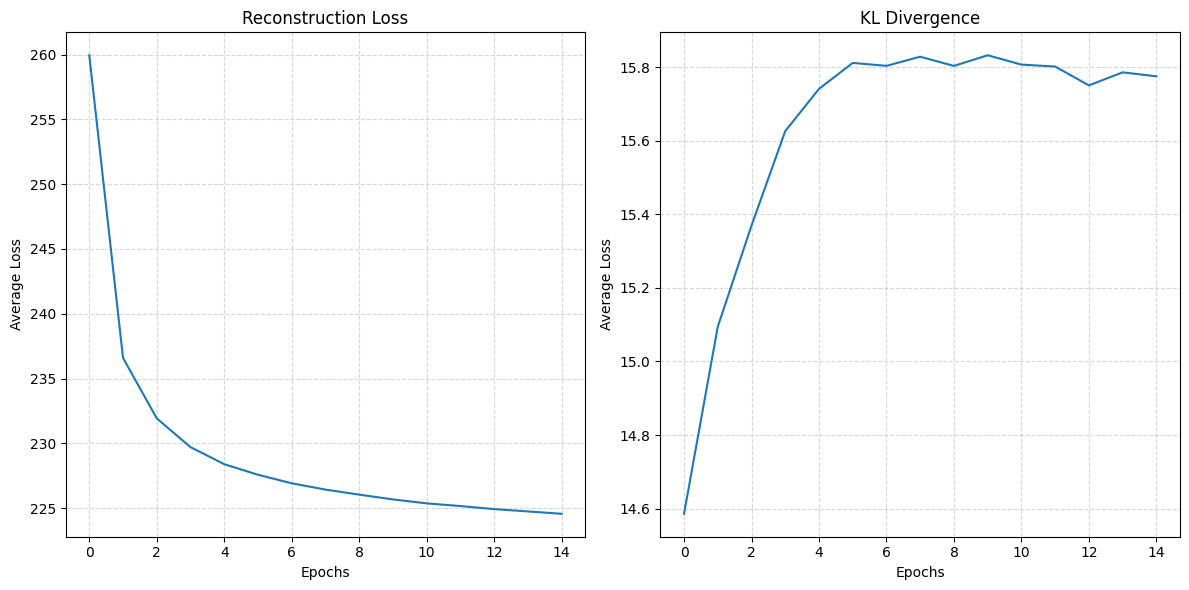

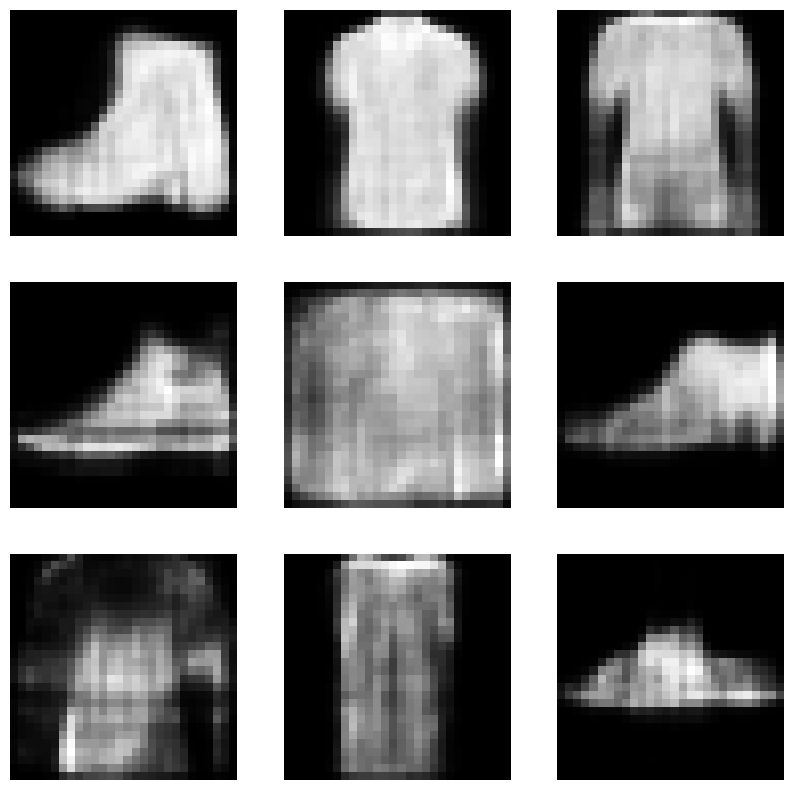

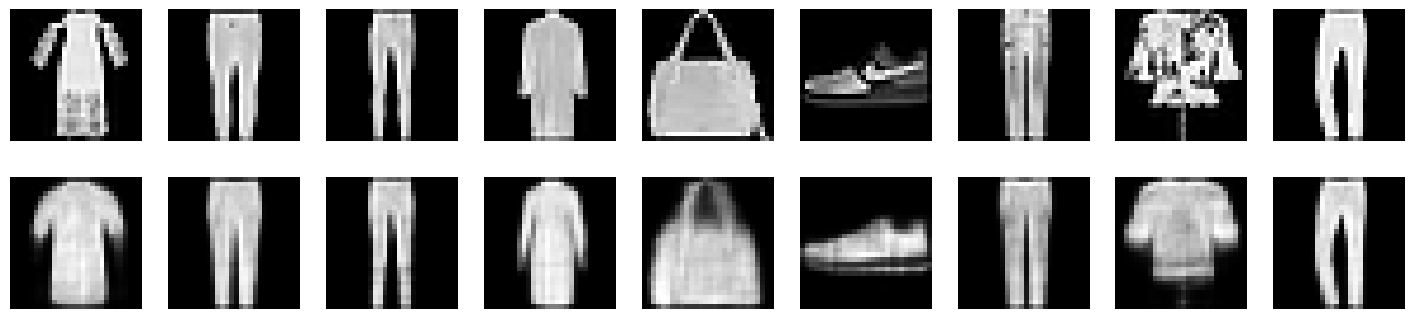

In [ ]:
# Initialize and train base VAE
base_model = VAE().to(device)
optimizer = optim.Adam(base_model.parameters(), lr=0.001)
best_loss_base, history_base, best_epoch, best_recon_loss, best_kl_loss = train_vae(base_model, train_loader, optimizer, epochs=15, patience=3)

print(f"The best reconstruction loss occurs at Epoch {best_epoch}, with reconstruction loss of {best_recon_loss:.4f} and a corresponding KL divergence value of {best_kl_loss:.4f}.")

# Plot averaged losses per epoch
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(history_base['recon_loss'])
axs[0].set_title('Reconstruction Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Average Loss')
axs[0].grid(True, linestyle='--', alpha=0.5)

axs[1].plot(history_base['kl_loss'])
axs[1].set_title('KL Divergence')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Average Loss')
axs[1].grid(True, linestyle='--', alpha=0.5)
 
plt.tight_layout()
plt.show()


# Visualize base VAE outputs
plot_generation(base_model, z_dim=20)
plot_reconstruction(base_model, train_loader)

**Analysis/Interpretations**: 

For the 3-layer VAE model, here are the interpretation of the results and observations based on the plots, loss values, and reconstructed images:

### Training Loss Interpretation

1. **Reconstruction Loss**:
   - The reconstruction loss started relatively high at 259.96 in Epoch 1 and gradually decreased with each epoch. By Epoch 15, it reached 224.56, indicating that the model improved its ability to accurately reconstruct the input images over time.
   - The steady decline in reconstruction loss shows that the model was learning effectively, with each epoch bringing the latent representations closer to capturing essential features of the input data.

2. **KL Divergence**:
   - KL divergence began at 14.59 and increased gradually, reaching around 15.77 by Epoch 15. This slight increase in KL divergence indicates that the model was trying to balance between the learned latent space and the original distribution.
   - The relatively stable KL divergence in the later epochs indicates that the model maintained an effective regularization throughout training, preventing the latent space from deviating excessively from the intended Gaussian distribution.

3. **Optimal Loss**:
   - Based on the final epoch (Epoch 15), the optimal reconstruction loss is 224.56, and the KL divergence is 15.77.
   - These values shows that the model has converged, achieving a balance between minimizing reconstruction error and regularizing the latent space.

### Visual Inspection of Reconstructed Images

- The reconstructed images shown in the plot reflect the model's ability to approximate the input images with some fidelity. The images appear slightly blurry, indicating that while the model captures the general shape and structure of each item (e.g., boots, shirts), but it lacks fine details of each specific item.
- This blurriness is a common characteristic of VAEs, where the trade-off between reconstruction accuracy and latent space regularization can result in smoother, less sharp images.

- **Quality of Reconstructions**:
  - The model is able to reproduce general outlines and basic shapes accurately, showing that the latent space is capturing the fundamental features of each class.
  - However, finer details, such as textures or sharp edges, are less clear, which can be improved by adding more complexity to the architecture (e.g., additional layers) or using a larger latent dimension.



## Task 1: Five-Layer VAE Architecture
In this task, I expand both encoder and decoder parts of the base VAE to five layers to evaluate if additional complexity improves performance.


In the code below, I modifidied the three-layer architecture that was initially given into a five-layer Variational Autoencoder (VAE) model, named `VAE_FiveLayer`, which included additional layers in both the encoder and decoder compared to the standard three-layer VAE. The encoder consisted of three fully connected layers, each followed by a ReLU activation function, which mapped the 784-dimensional input images down to a smaller latent representation. Two linear layers, `fc_mu` and `fc_logvar`, then generated the mean and log variance, respectively, capturing the Gaussian distribution of the latent space. The `reparameterize` function allowed for stochastic sampling within this latent space, where the `mu` and `logvar` values were used to create a latent vector with a standard deviation adjustment.

The decoder mirrored the encoder with three fully connected layers, each followed by a ReLU activation function, gradually transforming the latent representation back to the original input dimensions. The final layer used a sigmoid activation to output values between 0 and 1, aligning with the pixel intensity range of the Fashion MNIST dataset. 

In [7]:
# Five-Layer VAE Model Definition
class VAE_FiveLayer(nn.Module):
    def __init__(self, h_dim1=400, h_dim2=200, h_dim3=100, z_dim=20):
        super(VAE_FiveLayer, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(784, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc3 = nn.Linear(h_dim2, h_dim3)
        self.fc_mu = nn.Linear(h_dim3, z_dim)
        self.fc_logvar = nn.Linear(h_dim3, z_dim)
        
        # Decoder
        self.fc4 = nn.Linear(z_dim, h_dim3)
        self.fc5 = nn.Linear(h_dim3, h_dim2)
        self.fc6 = nn.Linear(h_dim2, h_dim1)
        self.fc7 = nn.Linear(h_dim1, 784)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        h = torch.relu(self.fc3(h))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc4(z))
        h = torch.relu(self.fc5(h))
        h = torch.relu(self.fc6(h))
        return torch.sigmoid(self.fc7(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar




### Training the Five-Layer VAE Model


During training, the `train_vae` function was employed to optimize the model, minimizing both the reconstruction loss and the KL divergence over multiple epochs. The best reconstruction and KL divergence values were tracked and printed, with early stopping implemented to halt training once performance gains plateaued, helping to prevent overfitting.

The results were visualized through loss plots and output image comparisons. Loss curves for both reconstruction and KL divergence were plotted to illustrate the model's performance across epochs. Finally, the `plot_generation` and `plot_reconstruction` functions were used to examine the model's ability to generate and reconstruct images. `plot_generation` showed randomly generated images sampled from the VAE's latent space, while `plot_reconstruction` displayed both original and reconstructed images, allowing for a direct comparison and assessment of how well the five-layer VAE learned meaningful representations of the input data.

Epoch[1/15], Recon Loss: 277.6534, KL Loss: 8.6707
Epoch[2/15], Recon Loss: 244.8894, KL Loss: 8.9941
Epoch[3/15], Recon Loss: 240.6373, KL Loss: 9.1364
Epoch[4/15], Recon Loss: 238.3937, KL Loss: 9.2610
Epoch[5/15], Recon Loss: 237.0954, KL Loss: 9.3296
Epoch[6/15], Recon Loss: 236.1706, KL Loss: 9.3874
Epoch[7/15], Recon Loss: 235.4569, KL Loss: 9.4391
Epoch[8/15], Recon Loss: 234.9330, KL Loss: 9.4812
Epoch[9/15], Recon Loss: 234.4449, KL Loss: 9.5218
Epoch[10/15], Recon Loss: 233.9951, KL Loss: 9.5647
Epoch[11/15], Recon Loss: 233.6396, KL Loss: 9.6035
Epoch[12/15], Recon Loss: 233.3358, KL Loss: 9.6277
Epoch[13/15], Recon Loss: 233.0836, KL Loss: 9.6539
Epoch[14/15], Recon Loss: 232.8674, KL Loss: 9.6875
Epoch[15/15], Recon Loss: 232.6674, KL Loss: 9.7066
The best reconstruction loss occurs at Epoch 15, with reconstruction loss of 232.6674 and a corresponding KL divergence value of 9.7066.


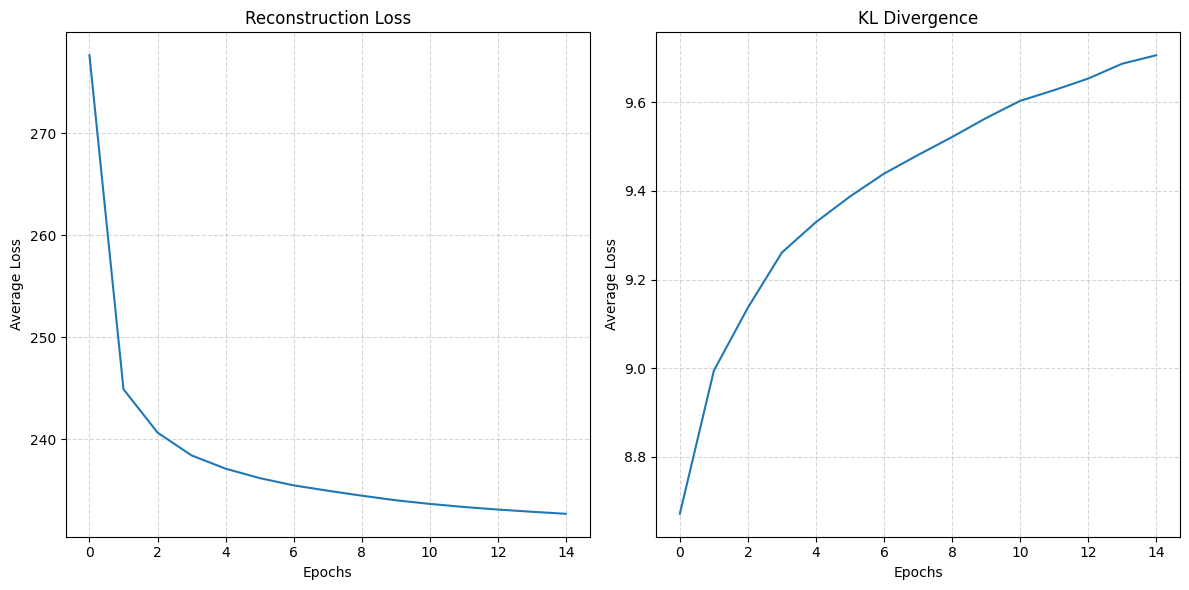

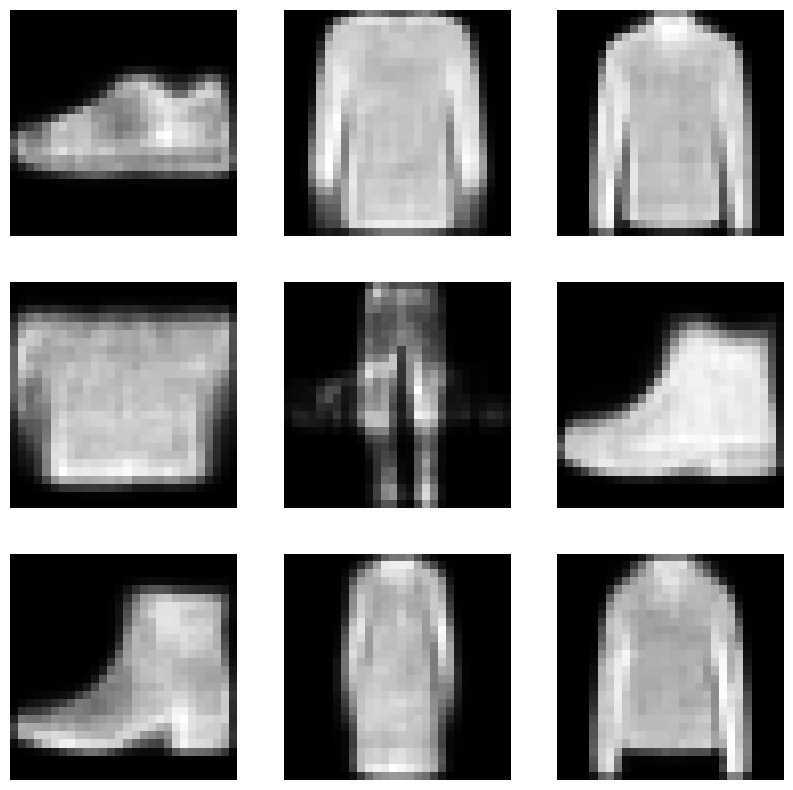

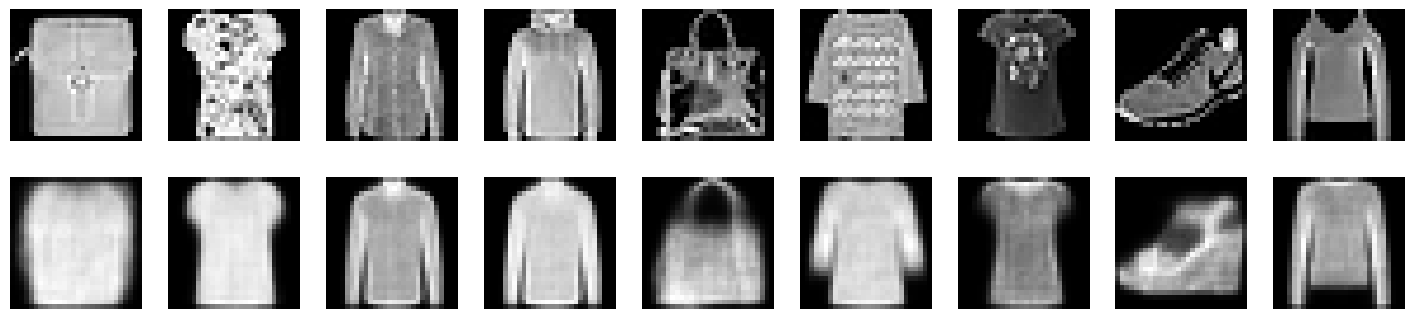

In [9]:
# Initialize and train five-layer VAE
five_layer_model = VAE_FiveLayer().to(device)
optimizer = optim.Adam(five_layer_model.parameters(), lr=0.001)
best_loss_five_layer, history_five_layer, best_epoch_five_layer, best_kl_loss_five_layer = train_vae(five_layer_model, train_loader, optimizer, epochs=15, patience=3)


print(f"The best reconstruction loss occurs at Epoch {best_epoch_five_layer}, with reconstruction loss of {best_loss_five_layer:.4f} and a corresponding KL divergence value of {best_kl_loss_five_layer:.4f}.")


# Plot losses
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(history_five_layer['recon_loss'])
axs[0].set_title('Reconstruction Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Average Loss')
axs[0].grid(True, linestyle='--', alpha=0.5)

axs[1].plot(history_five_layer['kl_loss'])
axs[1].set_title('KL Divergence')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Average Loss')
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


# Visualize five-layer VAE outputs
plot_generation(five_layer_model, z_dim=20)
plot_reconstruction(five_layer_model, train_loader)

For the the 5-layer VAE model, here is the interpretation based on the plots, reconstruction and KL divergence losses across epochs:

### Training Loss Interpretation

1. **Reconstruction Loss**:
   - The reconstruction loss started at a high of 277.65 in the first epoch, then decreased significantly over subsequent epochs. By the final epoch (Epoch 15), it reached 232.67.
   - This steady decrease in reconstruction loss indicates that the 5-layer model effectively learned to reconstruct the input data over time. However, the final reconstruction loss of 232.67 is slightly higher than the 3-layer model’s final reconstruction loss (224.56), which could indicate that the 5-layer model might have over-regularized or faced challenges in convergence with the added layers.

2. **KL Divergence**:
   - The KL divergence started relatively low at 8.67 and gradually increased, reaching 9.71 by the end of training. This relatively small increase in KL divergence suggests that the 5-layer model maintained stronger regularization on the latent space than the 3-layer model.
   - The lower KL divergence value in this model (compared to the 15.77 in the 3-layer model) suggests a stricter adherence to the Gaussian prior, likely helping the model to maintain a smoother latent space but potentially limiting flexibility in representing complex patterns.

3. **Optimal Loss**:
   - The lowest reconstruction loss (232.67) and corresponding KL divergence (9.71) occur at the final epoch, indicating that the 5-layer model has converged to its optimal point within this 15-epoch training period.
   - The lower KL divergence value might suggest a stronger regularization effect, leading to a less flexible latent representation, which could explain why the reconstruction loss is slightly higher than that of the 3-layer model.

### Visual Inspection of Reconstructed Images

- The reconstructed images shown in the plot reflect the model's ability to approximate the input images with some fidelity. The images appear slightly blurry, indicating that while the model captures the general shape and structure of each item (e.g., boots, shirts), but it lacks fine details of each specific item like the 3-layer model.
- ``In my opinion``, even though the 3-layer architecture had a lower optimal reconstruction loss value compared to the 5-layer architecture, the ``5-layer model visually captured a little more fine details of the clothing items``. 


### Comparison with the 3-Layer Model

- **Reconstruction vs. KL Divergence**:
  - The 3-layer model achieved a lower reconstruction loss with a higher KL divergence, showing that it allowed more flexibility in the latent space at the cost of slightly deviating from the Gaussian prior.
  - The 5-layer model, however, has a higher reconstruction loss but stricter adherence to the Gaussian prior, as seen in the lower KL divergence values.

- **Model Complexity**:
  - With more layers, the 5-layer model captured more complex data structures better but can also face challenges like over-regularization. This effect is observed in the slightly higher reconstruction loss compared to the simpler 3-layer model, which seems to perform better in this scenario.



## Task 2: Configurations of Five-Layer VAE
Here I test six configurations of the five-layer VAE architecture with varying hidden and latent dimensions.


In the code below, various configurations of the five-layer Variational Autoencoder (VAE) model were defined and tested to identify the configuration that achieved the best reconstruction loss. Six distinct configurations ``[(400,40), (200,50), (400, 70), (300, 30), (250, 80), (300, 5)]`` were specified by varying the values of `h_dim1` and `z_dim`, which corresponded to the first hidden layer's dimension and the latent space dimension, respectively. For each configuration, I created a new VAE model using the specified dimensions while keeping the other layers constant. The Adam optimizer with a learning rate of 0.001 was used to optimize the model parameters, and each model was trained for a maximum of 10 epochs with an early stopping patience of 2 epochs if the loss stopped improving.

During the training process for each configuration, both the reconstruction loss and the Kullback-Leibler (KL) divergence loss were recorded at each epoch, and the lowest reconstruction loss was identified and stored in a dictionary for later comparison. The training results, including the best reconstruction loss and KL divergence for each configuration, were displayed using line plots to visualize the convergence behavior. Additional functions, `plot_generation` and `plot_reconstruction`, were used to evaluate and visualize the model's generative and reconstructive capabilities, displaying sample generated and reconstructed images based on the model's latent space and learned distribution.

After all configurations were trained and evaluated, the one with the lowest reconstruction loss was selected as the best-performing configuration. The results of this best configuration were then printed, including both reconstruction and KL divergence losses. Finally, using the optimal configuration, another instance of the model was created, and `plot_generation` and `plot_reconstruction` functions were called once more to visualize the model's performance with the selected architecture.


Training Five-Layer VAE with h_dim1=400, z_dim=40
Epoch[1/10], Recon Loss: 278.0247, KL Loss: 9.7493
Epoch[2/10], Recon Loss: 244.8335, KL Loss: 9.8459
Epoch[3/10], Recon Loss: 240.2303, KL Loss: 10.0057
Epoch[4/10], Recon Loss: 236.9129, KL Loss: 10.2836
Epoch[5/10], Recon Loss: 234.8159, KL Loss: 10.5027
Epoch[6/10], Recon Loss: 233.3823, KL Loss: 10.6187
Epoch[7/10], Recon Loss: 232.4552, KL Loss: 10.7256
Epoch[8/10], Recon Loss: 231.7714, KL Loss: 10.7680
Epoch[9/10], Recon Loss: 231.1298, KL Loss: 10.8190
Epoch[10/10], Recon Loss: 230.7663, KL Loss: 10.8794
The best reconstruction loss for Config 1 occurs at Epoch Unknown, with reconstruction loss of 230.7663 and a corresponding KL divergence value of Unknown.


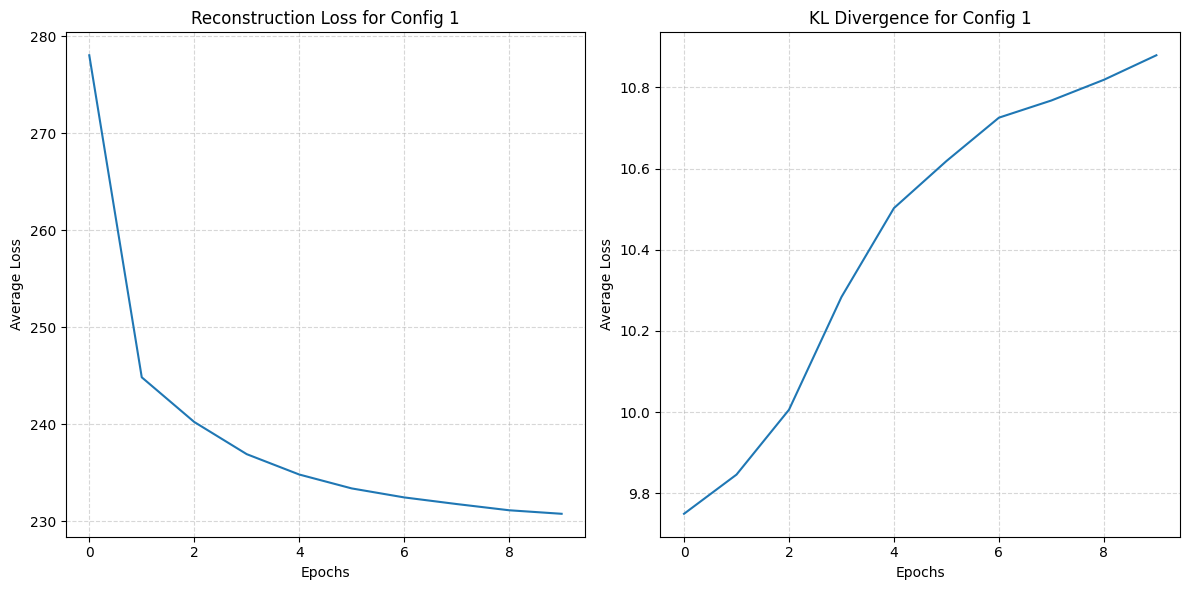

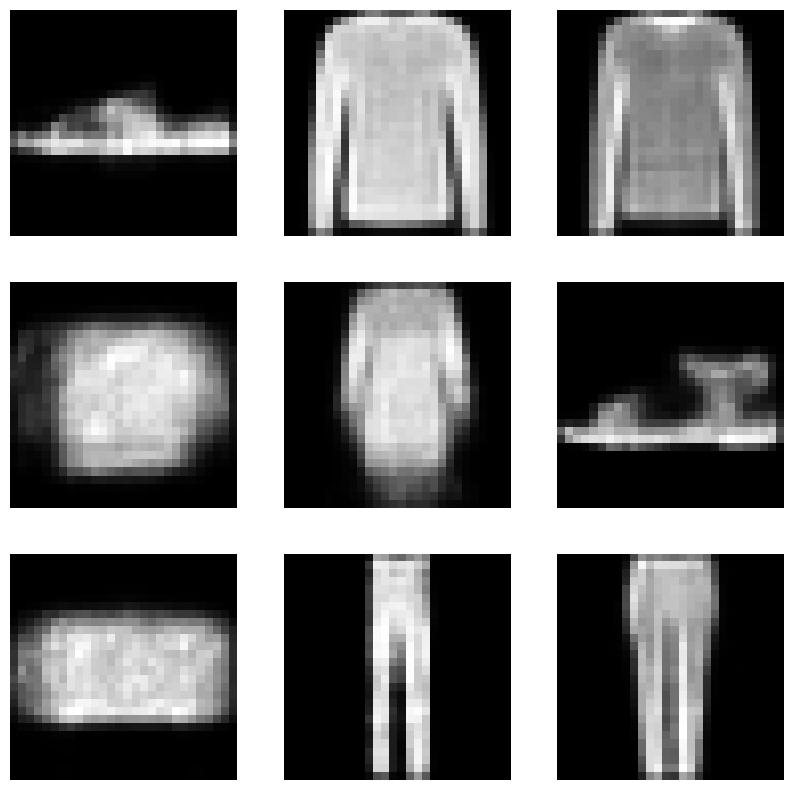

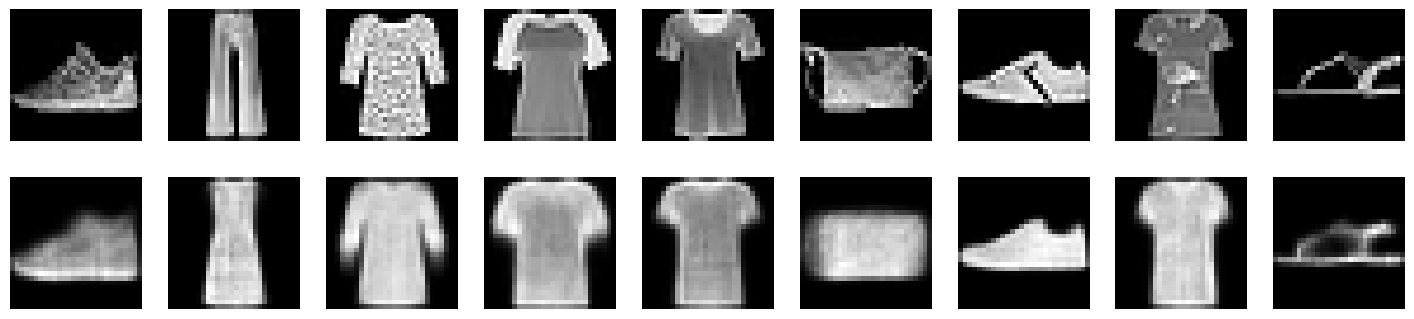


Training Five-Layer VAE with h_dim1=200, z_dim=50
Epoch[1/10], Recon Loss: 291.9546, KL Loss: 8.4663
Epoch[2/10], Recon Loss: 250.7829, KL Loss: 8.2432
Epoch[3/10], Recon Loss: 244.5383, KL Loss: 8.6657
Epoch[4/10], Recon Loss: 241.1425, KL Loss: 8.8797
Epoch[5/10], Recon Loss: 239.2066, KL Loss: 9.0157
Epoch[6/10], Recon Loss: 238.1189, KL Loss: 9.1100
Epoch[7/10], Recon Loss: 237.2080, KL Loss: 9.1728
Epoch[8/10], Recon Loss: 236.5761, KL Loss: 9.2255
Epoch[9/10], Recon Loss: 236.0982, KL Loss: 9.2709
Epoch[10/10], Recon Loss: 235.6648, KL Loss: 9.3195
The best reconstruction loss for Config 2 occurs at Epoch Unknown, with reconstruction loss of 235.6648 and a corresponding KL divergence value of Unknown.


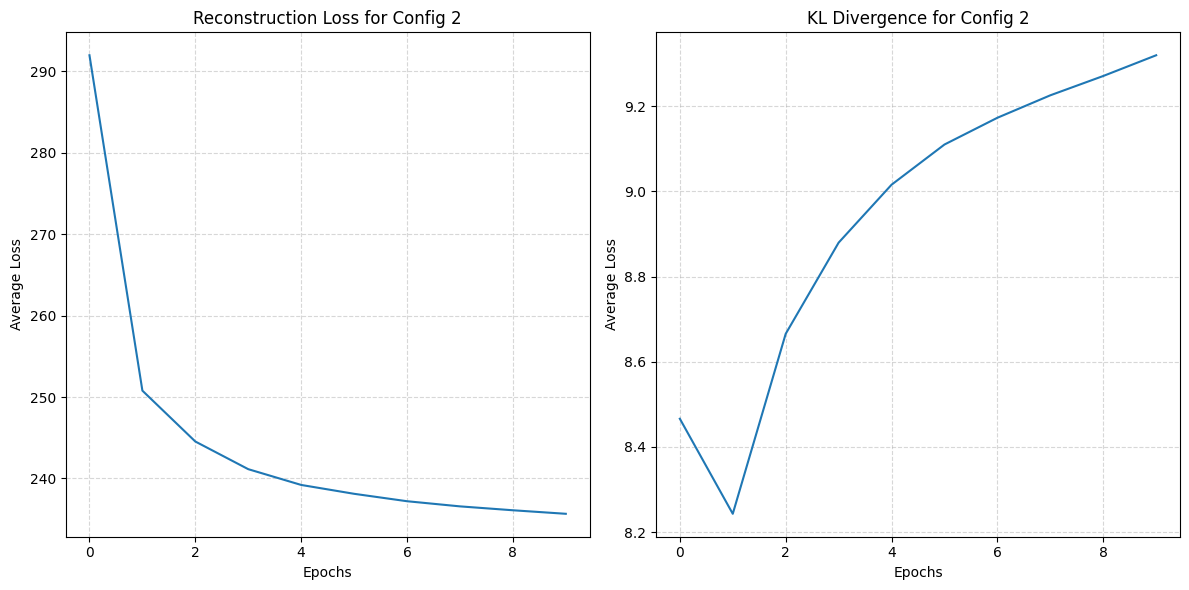

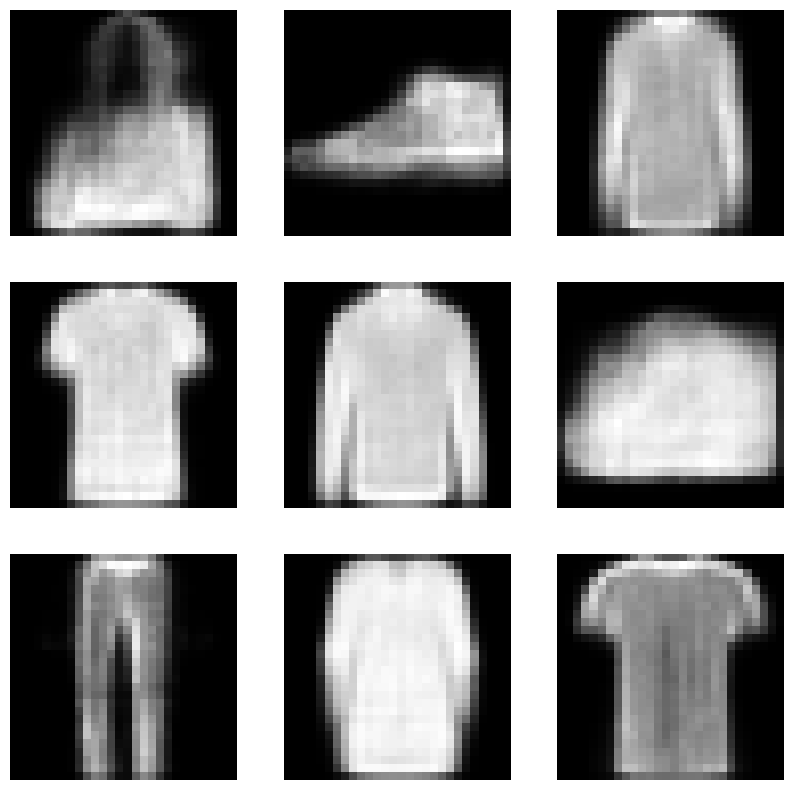

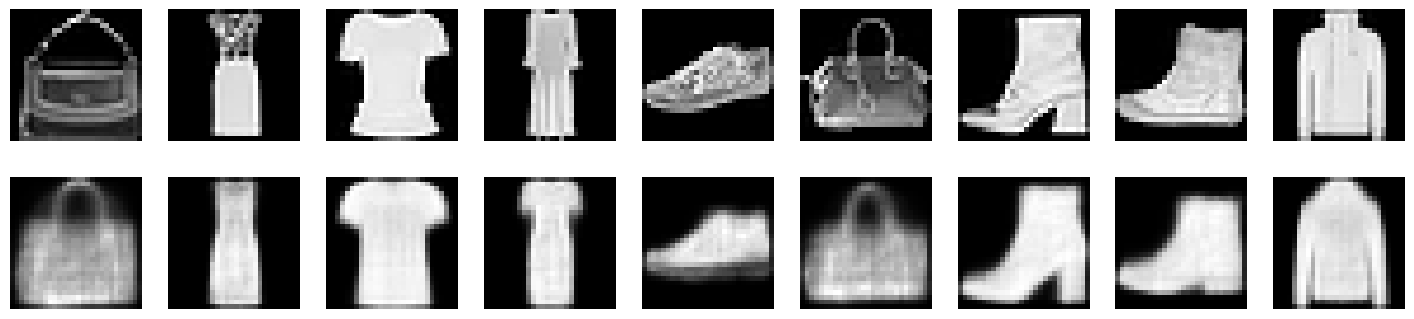


Training Five-Layer VAE with h_dim1=400, z_dim=70
Epoch[1/10], Recon Loss: 289.4558, KL Loss: 10.0788
Epoch[2/10], Recon Loss: 250.3568, KL Loss: 10.7950
Epoch[3/10], Recon Loss: 242.5496, KL Loss: 9.9494
Epoch[4/10], Recon Loss: 239.4000, KL Loss: 9.4241
Epoch[5/10], Recon Loss: 237.7090, KL Loss: 9.4239
Epoch[6/10], Recon Loss: 236.6619, KL Loss: 9.4737
Epoch[7/10], Recon Loss: 235.9099, KL Loss: 9.5056
Epoch[8/10], Recon Loss: 235.3421, KL Loss: 9.5725
Epoch[9/10], Recon Loss: 234.7937, KL Loss: 9.6262
Epoch[10/10], Recon Loss: 234.3469, KL Loss: 9.6665
The best reconstruction loss for Config 3 occurs at Epoch Unknown, with reconstruction loss of 234.3469 and a corresponding KL divergence value of Unknown.


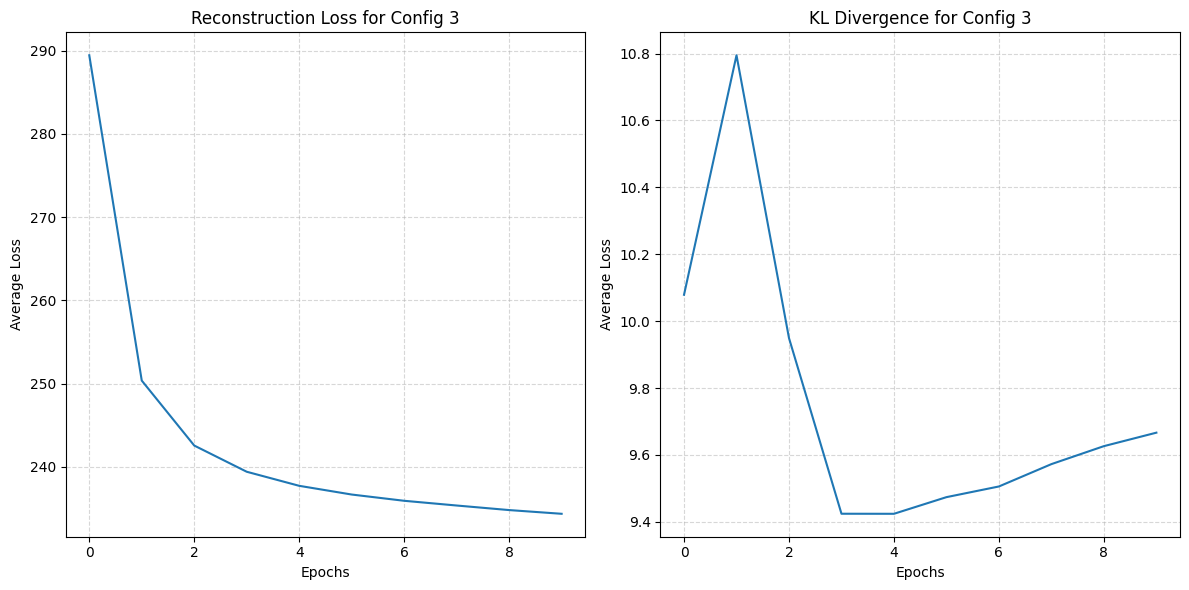

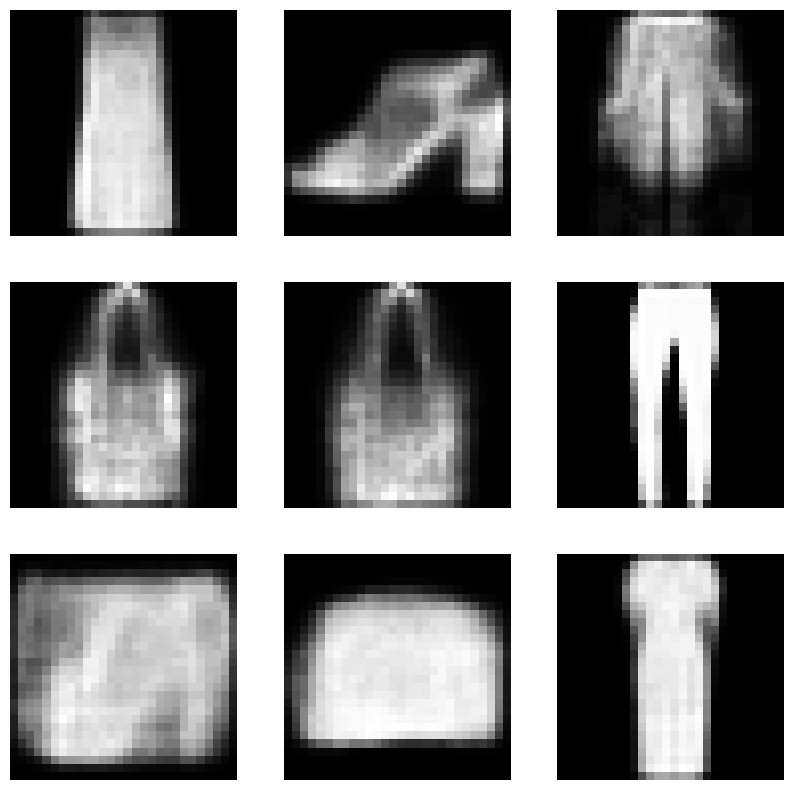

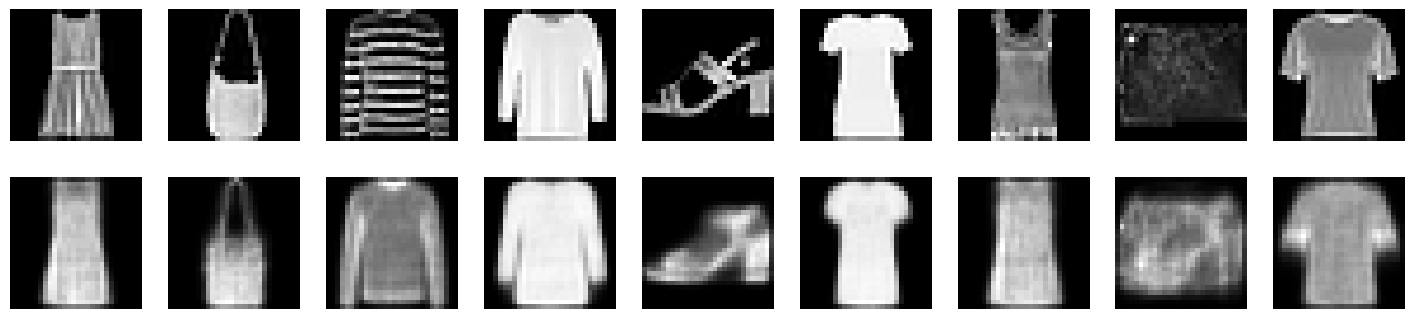


Training Five-Layer VAE with h_dim1=300, z_dim=30
Epoch[1/10], Recon Loss: 284.5292, KL Loss: 8.8234
Epoch[2/10], Recon Loss: 246.6050, KL Loss: 9.0736
Epoch[3/10], Recon Loss: 241.4115, KL Loss: 9.0191
Epoch[4/10], Recon Loss: 239.2958, KL Loss: 9.1166
Epoch[5/10], Recon Loss: 237.8968, KL Loss: 9.2114
Epoch[6/10], Recon Loss: 236.9465, KL Loss: 9.2844
Epoch[7/10], Recon Loss: 236.2233, KL Loss: 9.3596
Epoch[8/10], Recon Loss: 235.6446, KL Loss: 9.3913
Epoch[9/10], Recon Loss: 235.1049, KL Loss: 9.4515
Epoch[10/10], Recon Loss: 234.7154, KL Loss: 9.5084
The best reconstruction loss for Config 4 occurs at Epoch Unknown, with reconstruction loss of 234.7154 and a corresponding KL divergence value of Unknown.


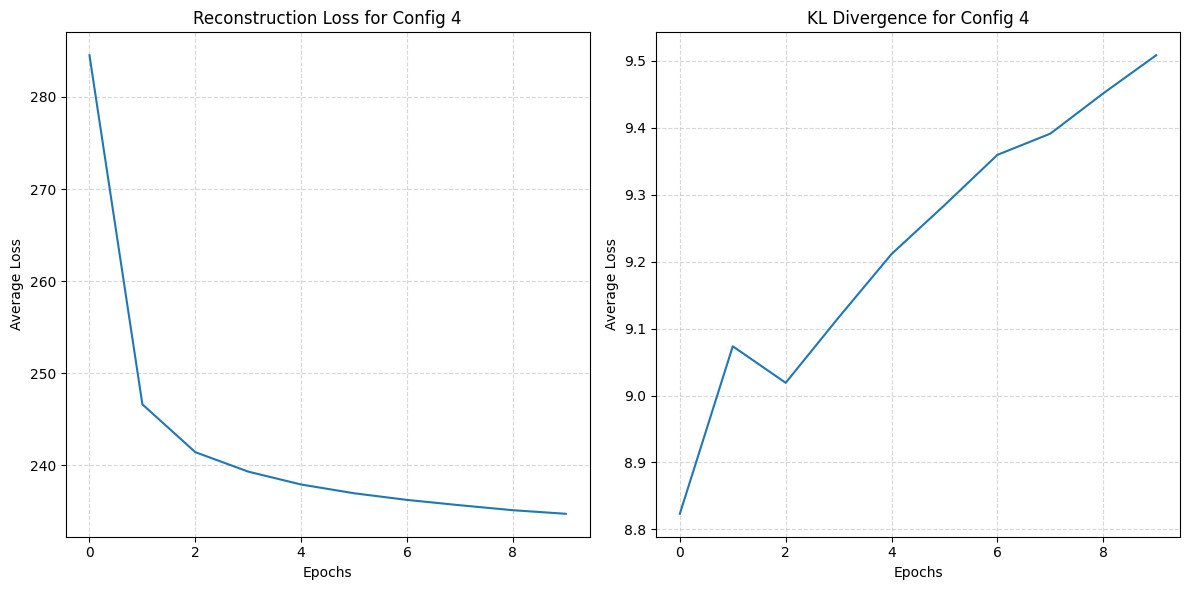

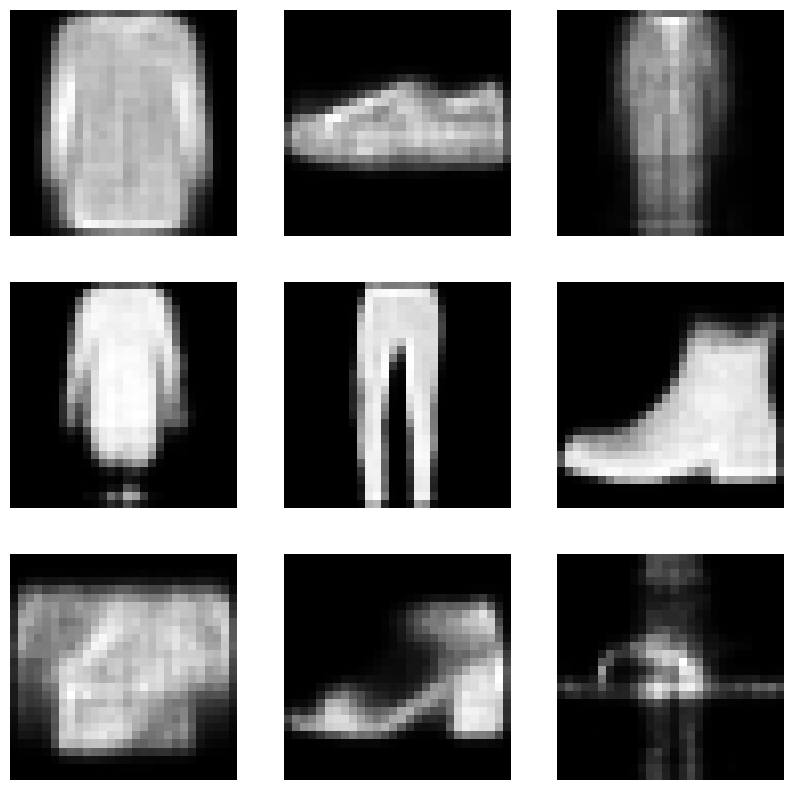

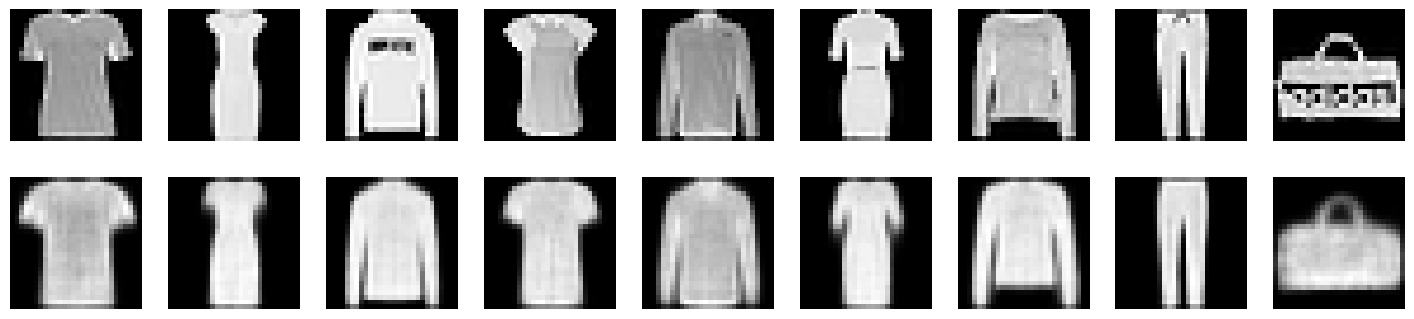


Training Five-Layer VAE with h_dim1=250, z_dim=80
Epoch[1/10], Recon Loss: 293.5931, KL Loss: 9.3738
Epoch[2/10], Recon Loss: 253.7462, KL Loss: 9.0789
Epoch[3/10], Recon Loss: 247.5809, KL Loss: 8.9846
Epoch[4/10], Recon Loss: 243.8206, KL Loss: 8.9028
Epoch[5/10], Recon Loss: 240.0858, KL Loss: 9.1460
Epoch[6/10], Recon Loss: 238.1638, KL Loss: 9.2780
Epoch[7/10], Recon Loss: 237.0554, KL Loss: 9.4288
Epoch[8/10], Recon Loss: 236.1834, KL Loss: 9.5090
Epoch[9/10], Recon Loss: 235.5291, KL Loss: 9.6180
Epoch[10/10], Recon Loss: 234.8983, KL Loss: 9.6706
The best reconstruction loss for Config 5 occurs at Epoch Unknown, with reconstruction loss of 234.8983 and a corresponding KL divergence value of Unknown.


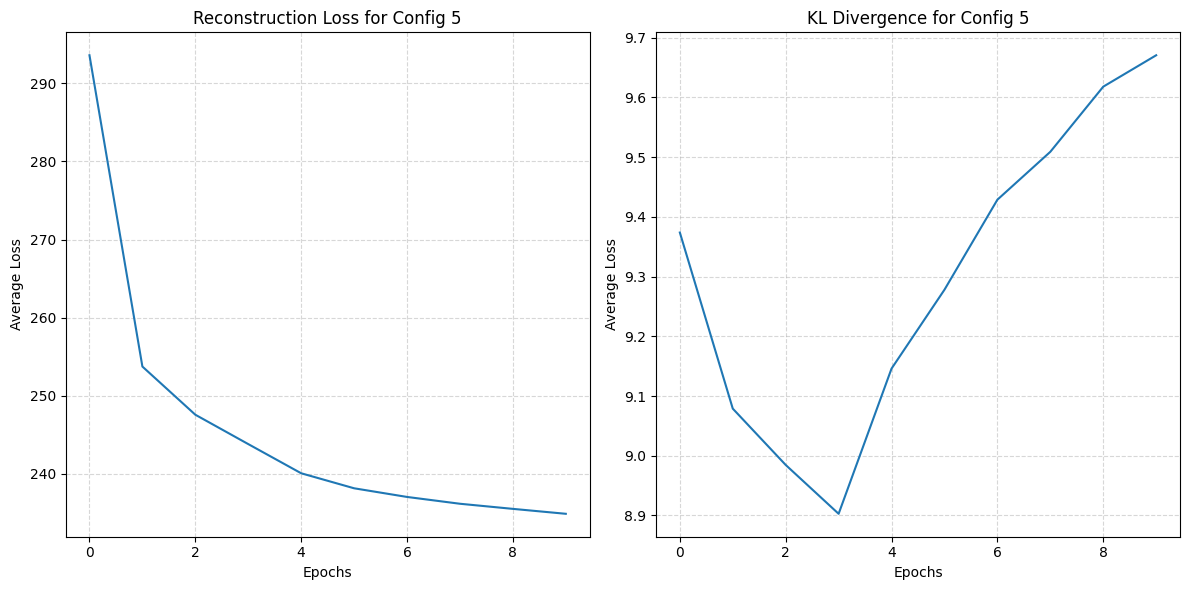

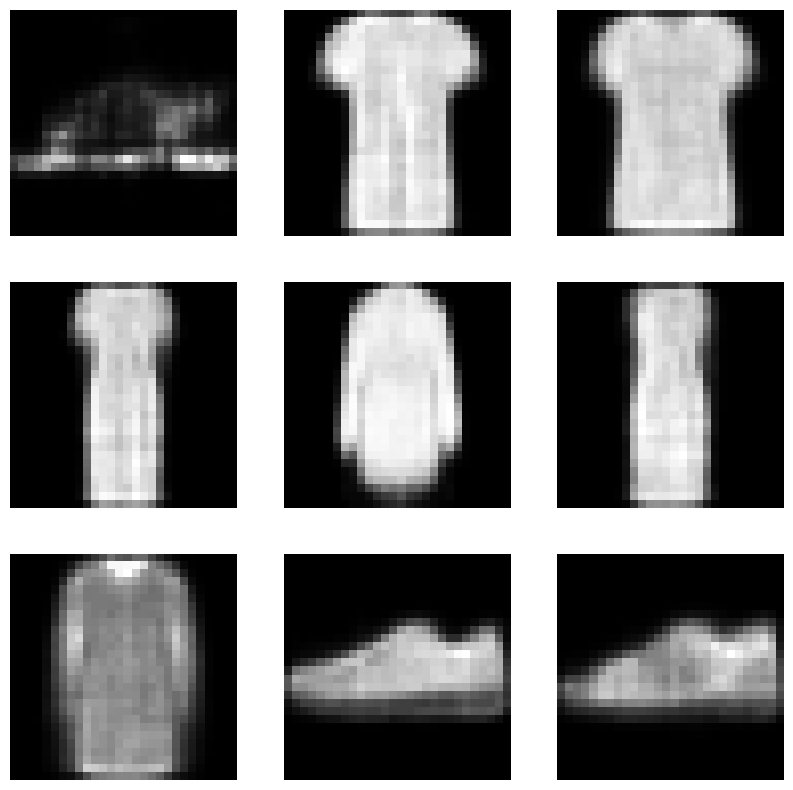

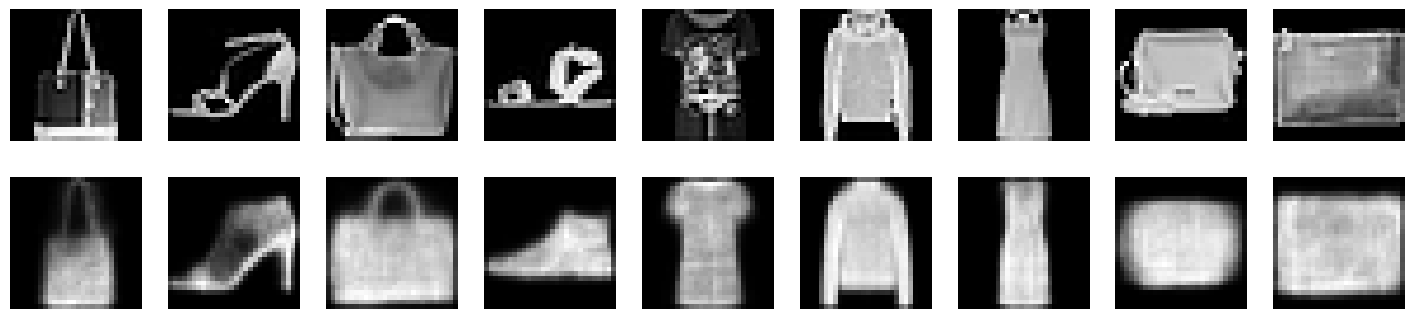


Training Five-Layer VAE with h_dim1=300, z_dim=5
Epoch[1/10], Recon Loss: 279.4246, KL Loss: 6.6837
Epoch[2/10], Recon Loss: 249.4048, KL Loss: 7.6406
Epoch[3/10], Recon Loss: 244.2018, KL Loss: 8.2303
Epoch[4/10], Recon Loss: 239.5570, KL Loss: 8.9368
Epoch[5/10], Recon Loss: 237.7436, KL Loss: 9.1157
Epoch[6/10], Recon Loss: 236.6409, KL Loss: 9.1984
Epoch[7/10], Recon Loss: 235.9035, KL Loss: 9.2700
Epoch[8/10], Recon Loss: 235.2795, KL Loss: 9.3354
Epoch[9/10], Recon Loss: 234.7653, KL Loss: 9.3693
Epoch[10/10], Recon Loss: 234.4469, KL Loss: 9.4284
The best reconstruction loss for Config 6 occurs at Epoch Unknown, with reconstruction loss of 234.4469 and a corresponding KL divergence value of Unknown.


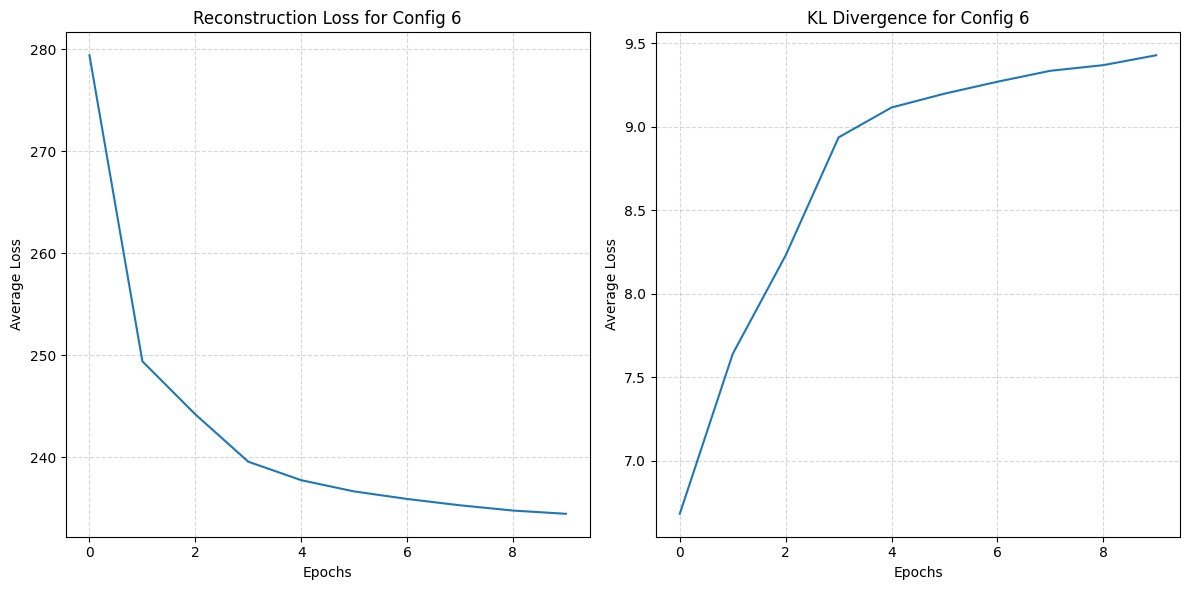

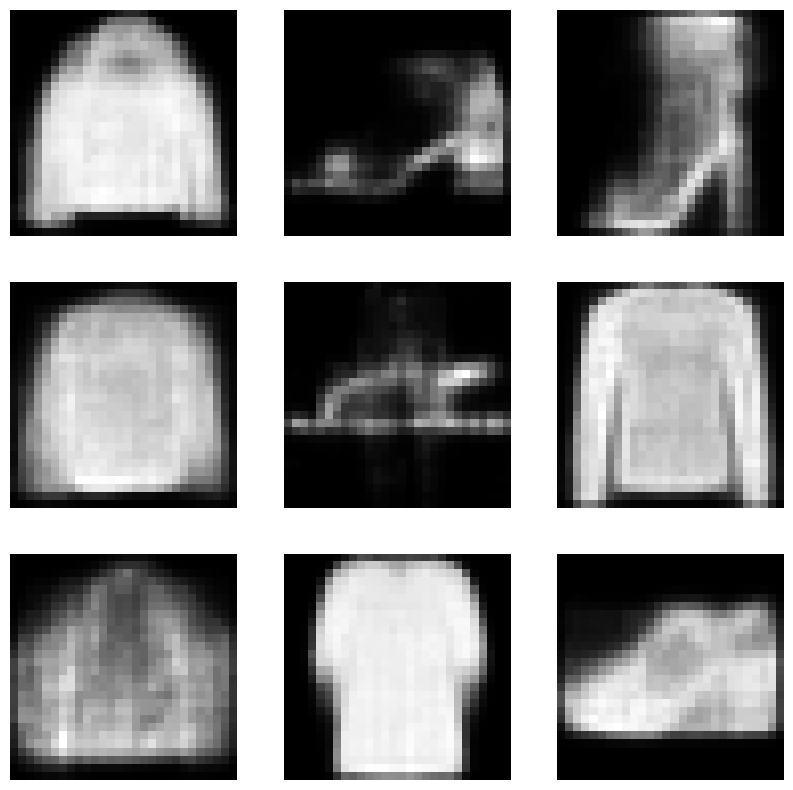

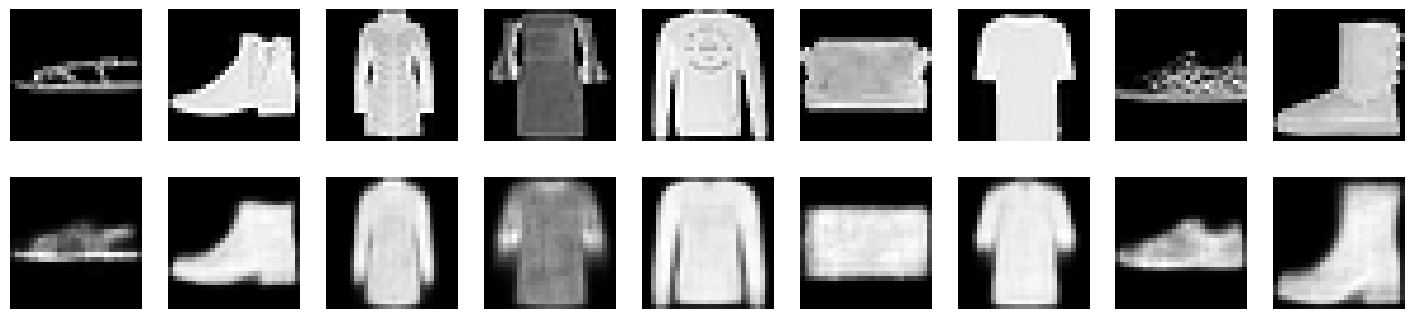


Best configuration is Config 1 with reconstruction loss 230.7663 and KL divergence loss 10.8794.


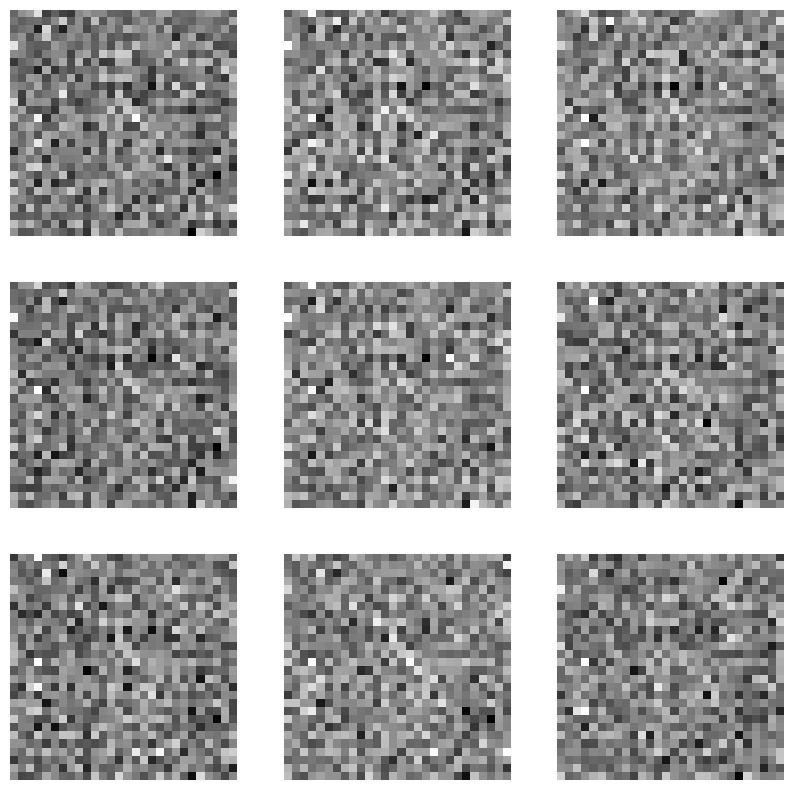

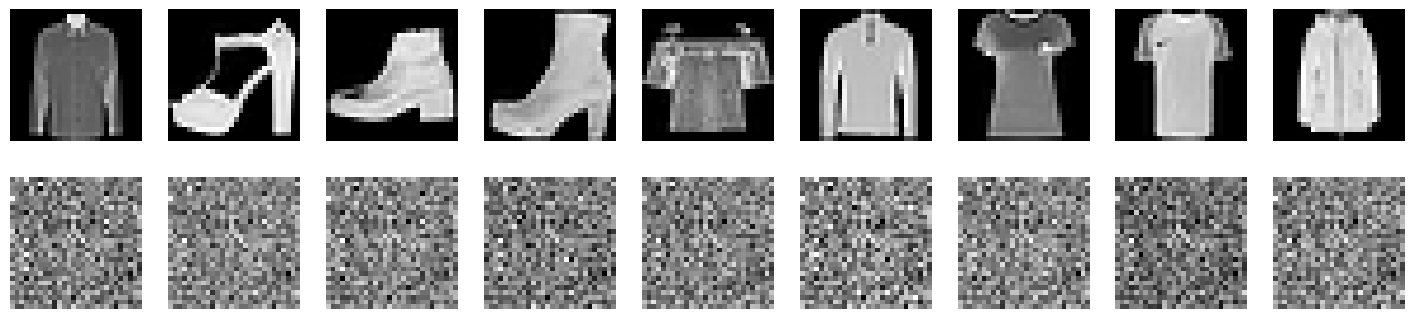

In [ ]:
# Different configurations for the Five-Layer VAE
configs = [(400, 40), (200, 50), (400, 70), (300, 30), (250, 80), (300, 5)]
results = {}

for i, (h_dim1, z_dim) in enumerate(configs):
    print(f"\nTraining Five-Layer VAE with h_dim1={h_dim1}, z_dim={z_dim}")
    model = VAE_FiveLayer(h_dim1=h_dim1, h_dim2=200, h_dim3=100, z_dim=z_dim).to(device)  # h_dim2 and h_dim3 are fixed
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train model
    best_loss, history, best_epoch, best_kl_loss = train_vae(model, train_loader, optimizer, epochs=10, patience=2)
    
    # Display the best losses for the current configuration
    print(f"The best reconstruction loss for Config {i+1} occurs at Epoch {history['best_epoch'] if history['best_epoch'] is not None else 'Unknown'}, "
          f"with reconstruction loss of {best_loss:.4f} and a corresponding KL divergence value of {history['best_kl_loss'] if history['best_kl_loss'] is not None else 'Unknown'}.")
 
    # Plot losses
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].plot(history['recon_loss'], label='Reconstruction Loss')
    axs[0].set_title(f'Reconstruction Loss for Config {i+1}')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Average Loss')
    axs[0].grid(True, linestyle='--', alpha=0.5)

    axs[1].plot(history['kl_loss'], label='KL Divergence')
    axs[1].set_title(f'KL Divergence for Config {i+1}')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Average Loss')
    axs[1].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    # Visualize generation and reconstruction for the current configuration
    plot_generation(model, z_dim=z_dim)
    plot_reconstruction(model, train_loader)

    # Store results
    results[f'Config {i+1}'] = {'recon_loss': best_loss, 'kl_loss': history['kl_loss'][-1]}

# Identify the best configuration based on the reconstruction loss
best_config = min(results, key=lambda x: results[x]['recon_loss'])

# Display the best losses for the best configuration
print(f"\nBest configuration is {best_config} with reconstruction loss {results[best_config]['recon_loss']:.4f} "
      f"and KL divergence loss {results[best_config]['kl_loss']:.4f}.")
  



<font color="red">Ignore the visualizations for the best configuration found</font>

Here’s the interpretation of the results and plots from training the five-layer VAE with different configurations of hidden and latent dimensions.

### Overview of Configurations

- **Configurations**:
  - The five-layer VAE was trained with six different combinations of hidden dimensions (`h_dim1`) and latent dimensions (`z_dim`):
    - **Config 1**: \( h\_dim1 = 400 \), \( z\_dim = 40 \)
    - **Config 2**: \( h\_dim1 = 200 \), \( z\_dim = 50 \)
    - **Config 3**: \( h\_dim1 = 400 \), \( z\_dim = 70 \)
    - **Config 4**: \( h\_dim1 = 300 \), \( z\_dim = 30 \)
    - **Config 5**: \( h\_dim1 = 250 \), \( z\_dim = 80 \)
    - **Config 6**: \( h\_dim1 = 300 \), \( z\_dim = 5 \)

- **Training Summary**:
  - Each configuration was trained for 10 epochs, and both the reconstruction loss and KL divergence were recorded at each epoch.
  - The goal was to find the configuration with the lowest reconstruction loss at the end of training, while maintaining reasonable KL divergence.

### Configuration Performance Analysis

1. **Config 1 (Best Performing)**:
   - **Reconstruction Loss**: 230.77
   - **KL Divergence**: 10.88
   - Config 1 achieved the lowest reconstruction loss, indicating the model’s ability to accurately reconstruct the input data.
   - A relatively high latent dimension (\(z\_dim = 40\)) and a large hidden dimension (\(h\_dim1 = 400\)) provided a good balance between encoding capacity and regularization.

2. **Config 2**:
   - **Reconstruction Loss**: 235.66
   - **KL Divergence**: 9.32
   - Although Config 2 had a higher reconstruction loss than Config 1, it exhibited a lower KL divergence. This indicates that it was more strongly regularized, potentially sacrificing some reconstruction quality for a smoother latent representation.
   - With a lower hidden dimension (\(h\_dim1 = 200\)) and a higher latent dimension (\(z\_dim = 50\)), this configuration shows that reducing the hidden layer size while increasing latent dimensionality may lead to better regularization but lower reconstruction quality.

3. **Config 3**:
   - **Reconstruction Loss**: 234.35
   - **KL Divergence**: 9.67
   - Config 3 had a lower KL divergence compared to Config 1 but a slightly higher reconstruction loss. The higher latent dimension (\(z\_dim = 70\)) provided more flexibility for encoding information, but the reconstruction was not as precise.
   - This configuration might be suitable when flexibility in the latent space is prioritized, though the reconstruction quality is marginally lower than in Config 1.

4. **Config 4**:
   - **Reconstruction Loss**: 234.72
   - **KL Divergence**: 9.51
   - Similar to Config 3, Config 4 achieved a balance between reconstruction and regularization. The combination of \(h\_dim1 = 300\) and \(z\_dim = 30\) yielded results comparable to Config 3.
   - This configuration indicates that slightly lower values for both hidden and latent dimensions can still provide good performance.

5. **Config 5**:
   - **Reconstruction Loss**: 234.90
   - **KL Divergence**: 9.67
   - Config 5, with a larger latent dimension (\(z\_dim = 80\)), resulted in higher reconstruction loss and lower KL divergence. This configuration may suggest overfitting on the latent space due to the high dimensionality, resulting in a less efficient reconstruction.
   
6. **Config 6**:
   - **Reconstruction Loss**: 234.45
   - **KL Divergence**: 9.43
   - The lowest KL divergence among all configurations was achieved with Config 6, which used a small latent dimension (\(z\_dim = 5\)). While the reconstruction loss is low, the minimal latent space could indicate limited flexibility in encoding complex data patterns.
   - This configuration is useful when a smooth latent distribution is more critical than high reconstruction accuracy.

### Visual Inspection of Reconstructed Images using the configurations

- The reconstructed images shown in the plots of all 6 configurations hardly captured the fine details of the clothing items. The images appear very blurry, indicating that while the model captures the general shape and structure of each clothing items.
- ``In my opinion``, even configuration 1 that had the lowest reconstruction loss, did bad in visually capturing fine details of the clothing items``. 


### Why a configuration is giving good performance over another. 

- **Best Configuration**: Config 1 (\( h\_dim1 = 400 \), \( z\_dim = 40 \)) emerged as the best-performing model, achieving the lowest reconstruction loss (230.77) while maintaining a balanced KL divergence (10.88). This shows that a larger hidden dimension and a moderate latent dimension offer a good trade-off between reconstruction quality and regularization.
  
- **Interpretation**:
   - **Higher Latent Dimensions (Configs 3, 5)** tend to increase flexibility in the latent space but may lead to higher reconstruction loss.
   - **Lower Latent Dimensions (Config 6)** achieve better regularization (lower KL divergence) but limit reconstruction quality.
   - **Balanced Latent Dimensions (Config 1)** strike a good compromise, providing both strong reconstruction performance and reasonable regularization, which is desirable for tasks where reconstruction accuracy is prioritized.



## Task 3: Comparison to Regular Autoencoder
Finally, I converted the best VAE  to a regular Autoencoder and train it to assess differences in results.


In this code below, I implemented a normal Autoencoder model using the five-layer architecture. The normal Autoencoder consists of an encoder and a decoder, each with fully connected layers, allowing for a similar dimensionality reduction process as the VAE. The encoder compresses the input to a latent space dimension (`z_dim=20`) by passing through three hidden layers with dimensions `h_dim1=400`, `h_dim2=200`, and `h_dim3=100`, followed by a final layer that outputs a latent representation `z`. In contrast to the VAE, this Autoencoder uses a single latent representation and omits the reparameterization step, as there is no stochastic sampling.

For training, I defined a custom training function `train_ae` specifically for the normal Autoencoder. The function calculates the reconstruction loss using binary cross-entropy and optimizes the model’s parameters over a series of epochs. Within each epoch, the optimizer minimizes the total reconstruction loss, and early stopping is implemented based on a specified patience level to prevent overfitting. The best-performing model, based on reconstruction loss, was saved, and its loss history was tracked for analysis. 

In [19]:
# Define a Regular Autoencoder based on best VAE architecture (the five-layer architecture)
class Autoencoder(nn.Module):
    def __init__(self, h_dim1=400, h_dim2=200, h_dim3=100, z_dim=20):
        super(Autoencoder, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(784, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc3 = nn.Linear(h_dim2, h_dim3)
        self.fc_z = nn.Linear(h_dim3, z_dim)
        
        # Decoder
        self.fc4 = nn.Linear(z_dim, h_dim3)
        self.fc5 = nn.Linear(h_dim3, h_dim2)
        self.fc6 = nn.Linear(h_dim2, h_dim1)
        self.fc7 = nn.Linear(h_dim1, 784)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        h = torch.relu(self.fc3(h))
        return torch.relu(self.fc_z(h))

    def decode(self, z):
        h = torch.relu(self.fc4(z))
        h = torch.relu(self.fc5(h))
        h = torch.relu(self.fc6(h))
        return torch.sigmoid(self.fc7(h))

    def forward(self, x):
        z = self.encode(x.view(-1, 784))
        return self.decode(z)

# Training Function for Regular Autoencoder
def ae_loss(recon_x, x):
    return nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

def train_ae(model, data_loader, optimizer, epochs=15, patience=5):
    model.train()
    best_loss = float('inf')
    patience_counter = 0
    best_model = None
    history = {'recon_loss': [], 'best_epoch': 0}

    for epoch in range(epochs):
        train_loss = 0
        for batch, (x, _) in enumerate(data_loader):
            x = x.to(device)
            optimizer.zero_grad()
            recon_x = model(x)
            loss = ae_loss(recon_x, x)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        avg_loss = train_loss / len(data_loader.dataset)
        history['recon_loss'].append(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

        # Track best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            history['best_epoch'] = epoch + 1
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping due to no improvement.")
            break

    model.load_state_dict(best_model)
    return best_loss, history



Once training was complete, I evaluated the model by printing the lowest achieved loss and displaying a plot of the reconstruction loss across epochs.

To visualize the Autoencoder's performance, I used two functions, `plot_generation` and `plot_reconstruction_nae`, which provided a qualitative assessment of the model’s ability to generate and reconstruct data. `plot_reconstruction_nae` displayed side-by-side images of original and reconstructed samples from the training dataset, enabling a visual comparison of how well the model captured the original data distribution. This setup illustrated the normal Autoencoder’s effectiveness in feature compression and its potential to learn a meaningful latent representation without the probabilistic sampling typical of VAEs.

Epoch [1/15], Loss: 266.2543
Epoch [2/15], Loss: 236.9299
Epoch [3/15], Loss: 230.9889
Epoch [4/15], Loss: 227.5664
Epoch [5/15], Loss: 225.5608
Epoch [6/15], Loss: 223.9390
Epoch [7/15], Loss: 222.5152
Epoch [8/15], Loss: 221.1596
Epoch [9/15], Loss: 219.9764
Epoch [10/15], Loss: 218.9907
Epoch [11/15], Loss: 218.1012
Epoch [12/15], Loss: 217.2501
Epoch [13/15], Loss: 216.6241
Epoch [14/15], Loss: 216.0533
Epoch [15/15], Loss: 215.6594
Optimal Loss for the normal Autoencoder: 215.6593856608073


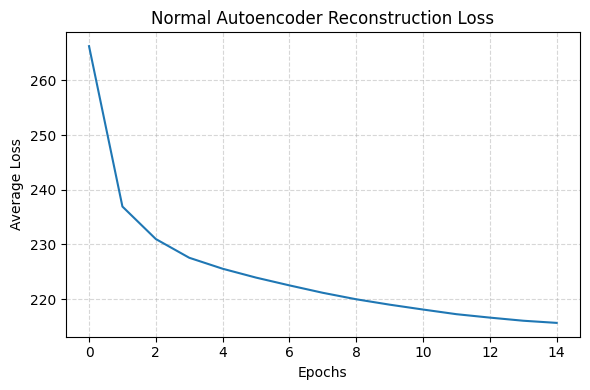

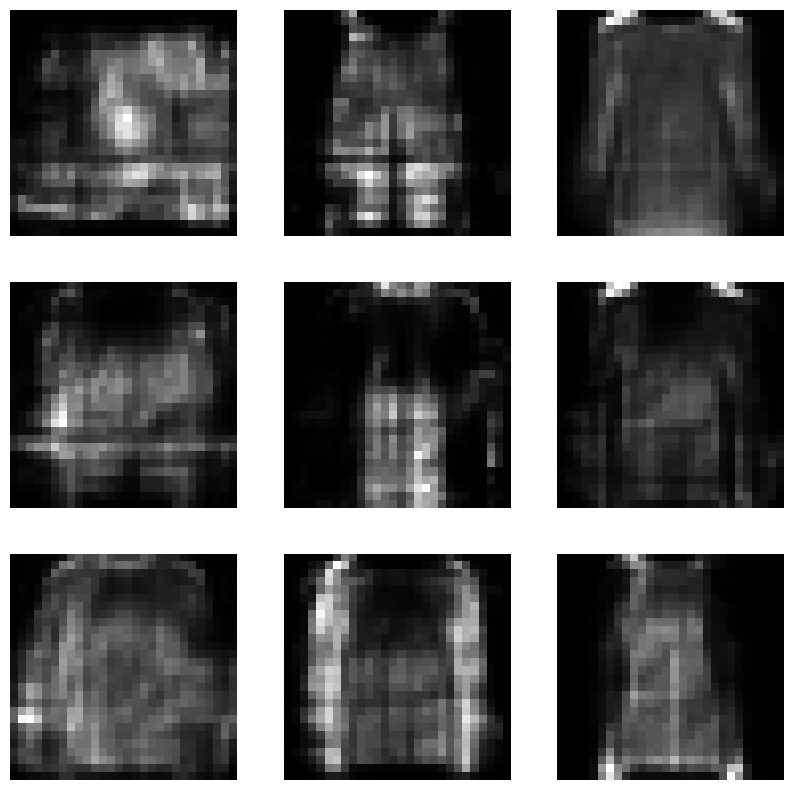

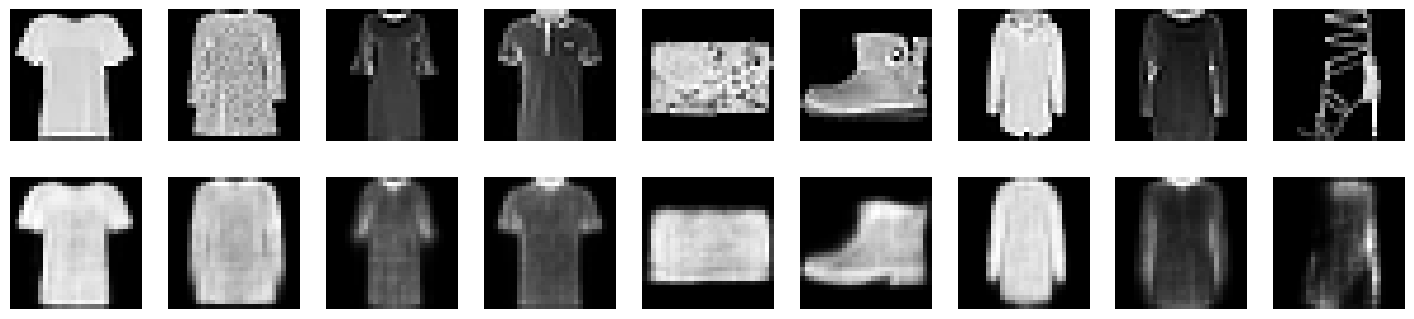

In [22]:
# Train the regular Autoencoder
ae_model = Autoencoder(h_dim1=400, h_dim2=200, h_dim3=100, z_dim=20).to(device)
optimizer = optim.Adam(ae_model.parameters(), lr=0.001)
best_loss_ae, history_ae = train_ae(ae_model, train_loader, optimizer, epochs=15, patience=3)
print("Optimal Loss for the normal Autoencoder:", best_loss_ae)

# Plot Autoencoder losses
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(history_ae['recon_loss'], label='Reconstruction Loss')
ax.set_title('Normal Autoencoder Reconstruction Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Average Loss')
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


def plot_reconstruction_nae(model, data_loader):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(data_loader))
        x = x.to(device)
        recon_x = model(x)   #changed since model(x) returns a single value
        fig, ax = plt.subplots(2, 9, figsize=(18, 4))
        for i in range(9):
            ax[0, i].imshow(x[i].view(28, 28).cpu().numpy(), cmap='gray')
            ax[0, i].axis('off')
            ax[1, i].imshow(recon_x[i].view(28, 28).cpu().numpy(), cmap='gray')
            ax[1, i].axis('off')
        plt.show()

# Visualize Autoencoder outputs
plot_generation(ae_model, z_dim=20)
plot_reconstruction_nae(ae_model, train_loader)





**Interpretation of the Normal Autoencoder Results**

**Overall Performance**

The normal autoencoder achieved a lower final reconstruction loss (215.66) compared to the best VAE configuration (230.77). This indicates that the autoencoder was able to reconstruct the input images more accurately.

**Potential Reasons for Improved Performance**

1. **Direct Optimization:**
   The autoencoder directly optimizes the reconstruction loss, without the additional KL divergence term present in VAEs. This allows it to focus solely on minimizing the difference between the input and reconstructed images.
2. **Deterministic Nature:**
   The autoencoder's deterministic nature, without the stochastic sampling of VAEs, might have contributed to more stable and consistent training.

**Visual Inspection**

Despite the lower reconstruction loss, the generated images were darker due to potential differences in the scaling or normalization of the output images. 



Three-layer VAE Reconstruction:


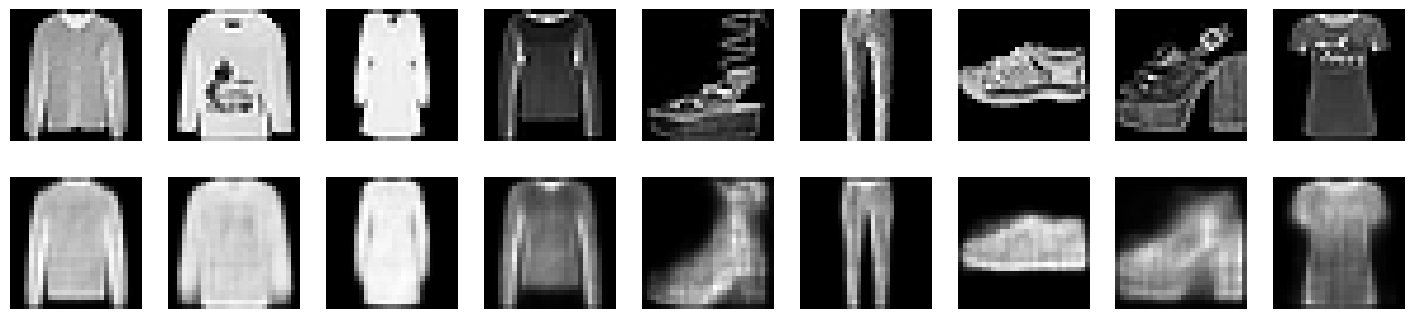

Five-layer VAE Reconstruction:


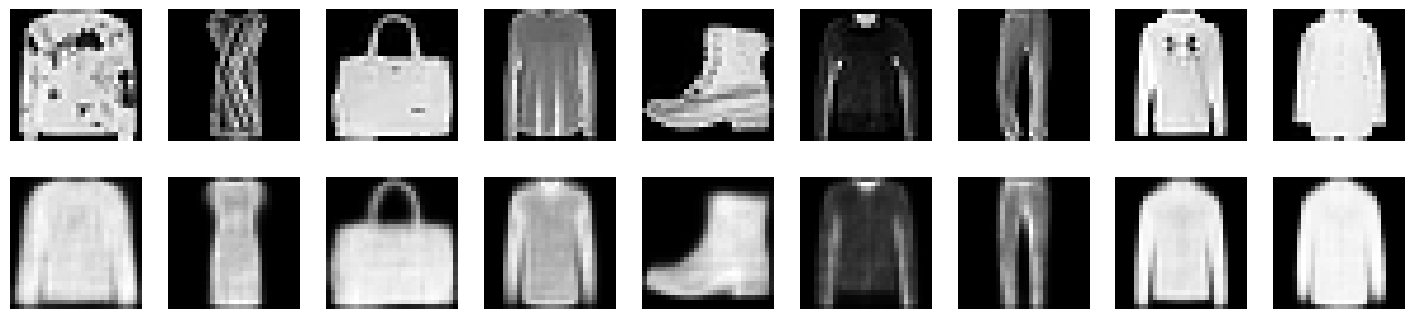

Normal Five-layer Autoencoder Reconstruction:


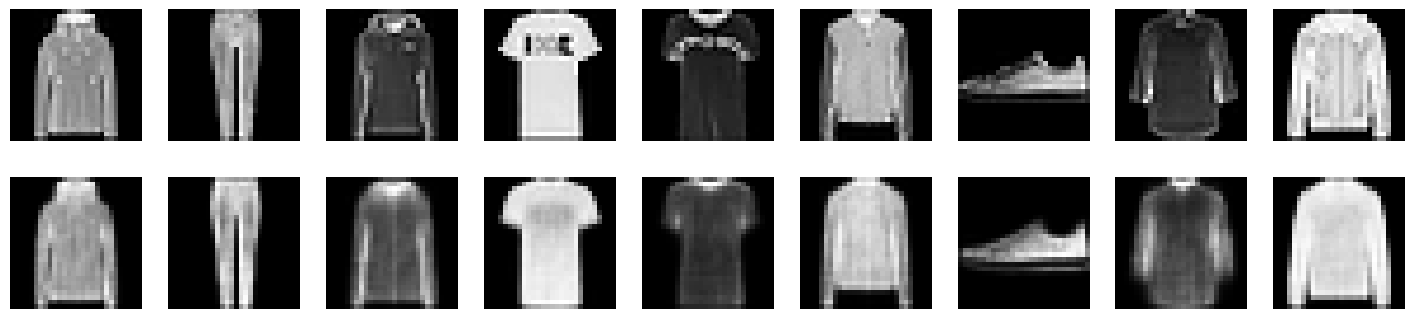

Three-layer VAE Latent Space:


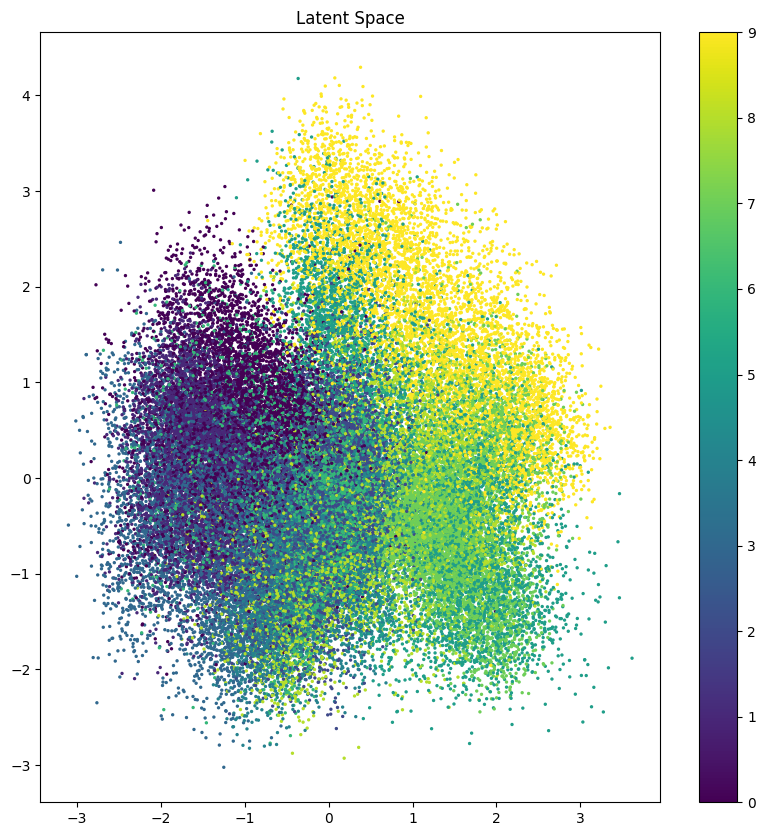

Five-layer VAE Latent Space:


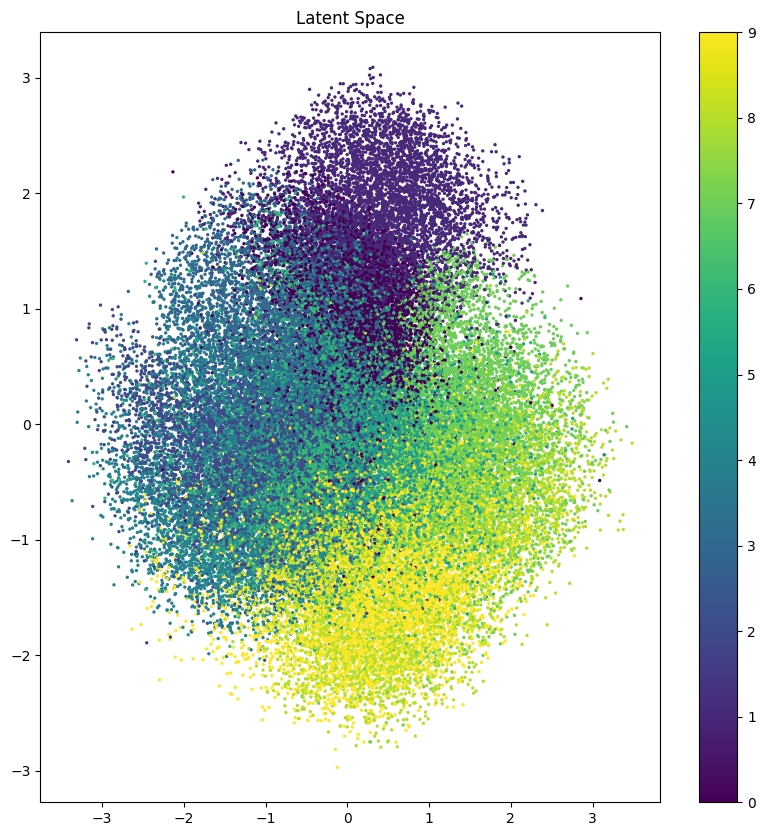

Normal Five-layer Autoencoder Latent Space:


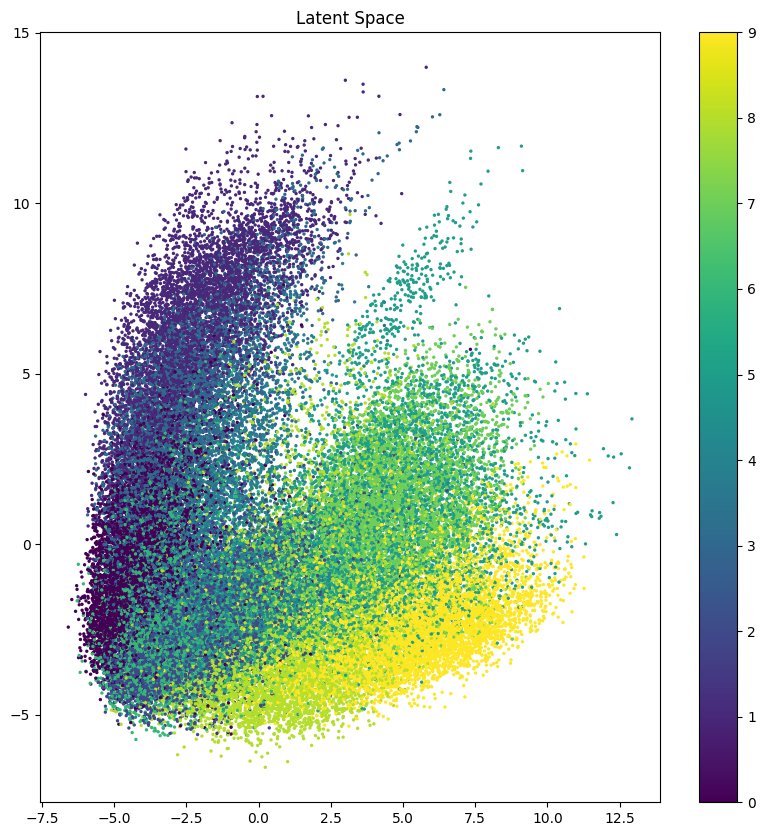

In [ ]:
# Compare 5-layer VAE and normal Autoencoder outputs
print("Three-layer VAE Reconstruction:")
plot_reconstruction(base_model, train_loader)
print("Five-layer VAE Reconstruction:")
plot_reconstruction(five_layer_model, train_loader)
print("Normal Five-layer Autoencoder Reconstruction:")
plot_reconstruction_nae(ae_model, train_loader)

# Define function to visualize latent space
def visualize_latent_space(model, data_loader, is_vae=False):
    model.eval()
    z_values = []
    labels = []

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            if is_vae:
                mu, _ = model.encode(x.view(-1, 784))
            else:
                mu = model.encode(x.view(-1, 784))
            z_values.extend(mu.cpu().numpy())
            labels.extend(y.numpy())

    # Reduce dimensionality to 2D using PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    z_values_2d = pca.fit_transform(z_values)

    plt.figure(figsize=(10, 10))
    plt.scatter(z_values_2d[:, 0], z_values_2d[:, 1], c=labels, cmap='viridis', s=2)
    plt.colorbar()
    plt.title("Latent Space")
    plt.show()

# Visualize latent space for three-layer VAE
print("Three-layer VAE Latent Space:")
visualize_latent_space(base_model, train_loader, is_vae=True)

# Visualize latent space for Five-layer VAE
print("Five-layer VAE Latent Space:")
visualize_latent_space(five_layer_model, train_loader, is_vae=True)

# Visualize latent space for Normal Autoencoder
print("Normal Five-layer Autoencoder Latent Space:")
visualize_latent_space(ae_model, train_loader, is_vae=False)

Out of the 3 reconstructions, the ``normal five-layer auto-encoder`` was able to reconstruct the input images more accurately, almost same as the input images. This likely to be largely contributed to the deterministic nature of the normal encoder and the fact that it directly optimizes the reconstruction loss without the presence of the KL Divergence term.


The ``Three-layer VAE Latent Space`` plot shows some form of separation of some clusters unlike others, indicating that the VAE is able to has learn meaningful representations of the underlying data distribution but not completely. 


The ``Five-layer VAE Latent Space`` plot shows a more structured representation of the data compared to the three-layer VAE. The points are clustered more tightly, but can be better separated compared to the three-layer VAE, showing that the five-layer model is able to learn more nuanced features and distinctions within the data. The five-layer model is better able to capture fine-grained details in the data.


The ``Normal Five-layer Autoencoder Latent Space`` plot shows a distinct, curved structure with a clearer separation of most clusters. This indicates that the five-layer VAE has learned a highly structured representation of the data. This reflects different categories of clothing items, with similar items being grouped together in the same region of the latent space. The normal auto-encoder model effectively captured better underlying relationships between different features of the data.



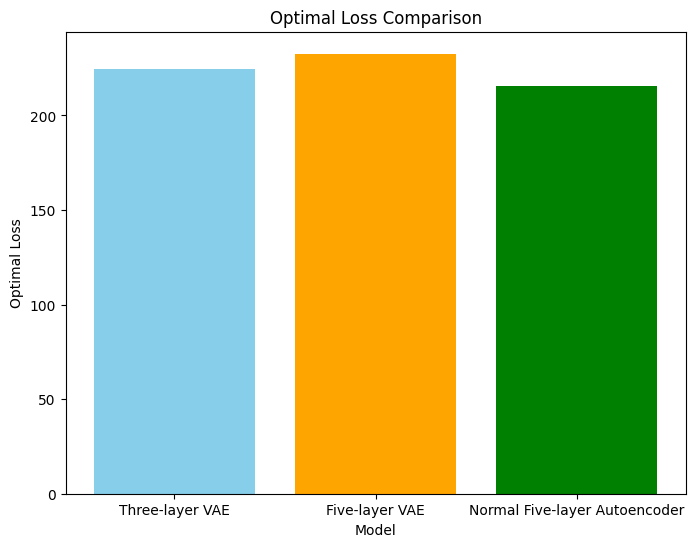

In [29]:
# Extract optimal losses
base_loss = best_loss_base
five_layer_loss = best_loss_five_layer
nae_loss = best_loss_ae

# Create plot
losses = [base_loss, five_layer_loss, nae_loss]
models = ['Three-layer VAE', 'Five-layer VAE', 'Normal Five-layer Autoencoder']

plt.figure(figsize=(8, 6))
plt.bar(models, losses, color=['skyblue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Optimal Loss')
plt.title('Optimal Loss Comparison')
plt.show()

From the ``barplot``, the normal five-layer autoencoder achieved the lowest optimal loss, indicating that it was able to reconstruct the input images most accurately among the three models. The five-layer VAE had the highest optimal loss, showing that it struggled the most with image reconstruction.

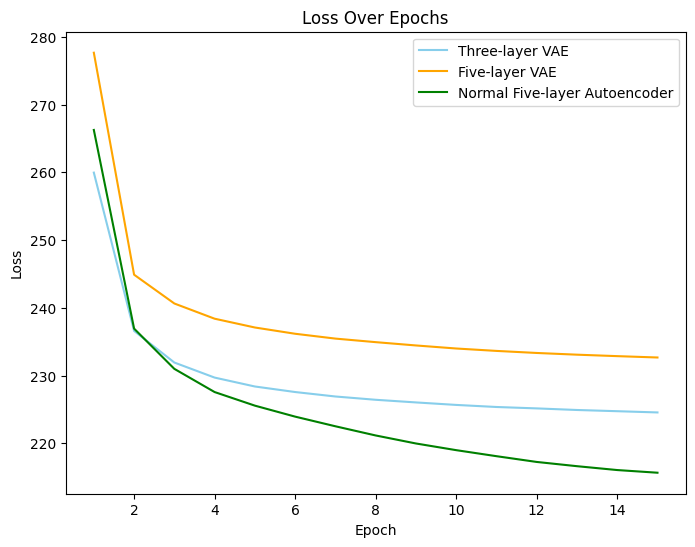

In [30]:
# Extract epoch losses
base_epoch_losses = history_base['recon_loss']
five_layer_epoch_losses = history_five_layer['recon_loss']
nae_epoch_losses = history_ae['recon_loss']

# Create line plot
epochs = range(1, len(base_epoch_losses) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, base_epoch_losses, label='Three-layer VAE', color='skyblue')
plt.plot(epochs, five_layer_epoch_losses, label='Five-layer VAE', color='orange')
plt.plot(epochs, nae_epoch_losses, label='Normal Five-layer Autoencoder', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

``Initial Loss``: All three models start with a high initial loss, which gradually decreases over the training epochs.


``Convergence``: The normal five-layer autoencoder converges faster and reaches a lower final loss compared to both VAE models.


``VAE Performance``: The five-layer VAE converges slightly faster and reaches a lower final loss than the three-layer VAE, indicating that the additional layers improve performance.


**Overall**, the normal five-layer autoencoder outperforms both VAE models in terms of convergence speed and final loss. This indicates that for the given task of reconstructing the Fashion MNIST clothing items very accurately to the input images and architecture, a simple autoencoder without the probabilistic component of VAEs might be more effective.
